In [1]:
from scipy.io import loadmat
from matplotlib import pyplot
from matplotlib.pyplot import *
import pandas as pd
import numpy

In [2]:
file_dir = "./data/"
mat_name = "Mdata.mat"
log_name = "AcuityLog_2019_08_19_10_50_10.txt"
C_limit1 = -0.1
C_limit2 = 1.1
eye_left = -800
eye_right = 500
S_eye_left = -100
S_eye_right = 900
speed_TH = 40
pyplot.rcParams["figure.figsize"] = (20,10)

In [3]:
class Section:
    
    def __init__(self,mode):
        self.sub_index = 0
        self.mode = mode
        self.AZ_RW_dir = []
        self.delay_RW = []
        self.move_target = []
        self.AZ_percent = {}
        self.delay_percent = {}
        self.eye_samples = []
        
    def cal_AC(self):
        AZ_RI_TO = {}
        for ARD in self.AZ_RW_dir:
            if(ARD[0] in AZ_RI_TO):
                AZ_RI_TO[ARD[0]][1] += 1
            else:
                AZ_RI_TO[ARD[0]] = [0,1]
            if(ARD[1] == 1):
                AZ_RI_TO[ARD[0]][0] += 1
        for ART in AZ_RI_TO.keys():
            self.AZ_percent[ART] = float(AZ_RI_TO[ART][0]) / float(AZ_RI_TO[ART][1])
    
    def cal_delay(self):
        DE_RI_TO = {}
        for DR in self.delay_RW:
            if(DR[0] in DE_RI_TO):
                DE_RI_TO[DR[0]][1] += 1
            else:
                DE_RI_TO[DR[0]] = [0,1]
            if(DR[1] == 1):
                DE_RI_TO[DR[0]][0] += 1
        for DRT in DE_RI_TO.keys():
            self.delay_percent[DRT] = float(DE_RI_TO[DRT][0]) / float(DE_RI_TO[DRT][1])

In [4]:
class MatData:
    
    def __init__(self):
        self.init_sample = 0
        self.SA_HS_LES_RES = []
        self.skip_index = []
        self.gaze_speed = []
        self.eye_index = 0
        
    def gaze_cal(self):
        self.gaze_speed = self.SA_HS_LES_RES[:,self.eye_index + 2] + self.SA_HS_LES_RES[:,1]

In [5]:
def read_file(AF_name, DF_name,sectionN = 0):
    try:
        file = open(file_dir+AF_name,"r")
        lines = file.readlines()
    except:
        lines = []
    
    section = Section("")
    
    start_flag = False
    S_index = 0
    last_delay = 0.0
    sample = 0
    for line in lines:
        strings = line.split()
        if(len(strings)<1):
            continue
        if(strings[1] == "start"):
            if(S_index == sectionN):
                start_flag = True
                section.mode = strings[4]
            else:
                start_flag = False
            S_index += 1
        if(start_flag):
            try:
                AZ = int(strings[3])
            except:
                AZ = -100
            if(AZ >= 0):
                RW = 1 if (strings[4] == "True") else 0
                section.AZ_RW_dir.append((AZ,RW,strings[5]))
                section.delay_RW.append((last_delay,RW))
            if(AZ == -2):
                try:
                    last_delay = float(strings[4])
                except:
                    last_delay = -1.0
                try:
                    sample = int(strings[1])
                except:
                    sample = -1
                section.eye_samples.append(sample)
    file.close()
    
    try:
        file = open(file_dir+DF_name,"r")
        lines = file.readlines()
    except:
        lines = []
    
    for line in lines:
        strings = line.split()
        if(len(strings)<1):
            continue
        if(strings[4] == "MoveTarget"):
            try:
                simS = int(strings[2])
                degree = float(strings[5]) if (strings[6] == "1") else -(float(strings[5]))
            except:
                simS = int(-1)
                degree = 0.0
            section.move_target.append((simS,degree))
            
            
    return section

In [6]:
def read_mat(filename):
    MD = MatData()
    file = loadmat(file_dir+filename)
    MD.init_sample = file['sampleNo'][0]
    MD.SA_HS_LES_RES = numpy.column_stack((file['sampleNo'],file['head'][0][0][1][:,2],file['leftEye'][0][0][1][:,2],file['rightEye'][0][0][1][:,2]))
    return MD

In [7]:
def plot_eye_single1(index, mat_data):
    labels = ["HeadSpeed","EyeSpeed","GazeSpeed"]
    x_data = range(0,S_eye_right-S_eye_left)
    y_data = []
    tpls = []
    start = int(index + eye_left)
    end = int(index + eye_right)
    T_index = -1
    for i in range(start,end):
        if(abs(mat_data.SA_HS_LES_RES[i,1]) > speed_TH):
            T_index = i
            break
    T_start = T_index + S_eye_left
    T_end = T_index + S_eye_right
    
    print(T_start)
    
    y_data = mat_data.SA_HS_LES_RES[int(T_start):int(T_end),1]
    tpl, = plot(x_data,y_data,label = labels[0])
    tpls.append(tpl)
    
    y_data = mat_data.SA_HS_LES_RES[int(T_start):int(T_end),mat_data.eye_index + 2]
    tpl, = plot(x_data,y_data,label = labels[1])
    tpls.append(tpl)
    
    y_data = mat_data.gaze_speed[int(T_start):int(T_end)]
    tpl, = plot(x_data,y_data,label = labels[2])
    tpls.append(tpl)
    return tpls

In [8]:
def plot_eye_single2(index, mat_data):
    labels = ["HeadSpeed","EyeSpeed","GazeSpeed"]
    x_data = range(0,eye_right-eye_left)
    y_data = []
    tpls = []
    start = int(index + eye_left)
    end = int(index + eye_right)
    
    print(start)
    
    y_data = mat_data.SA_HS_LES_RES[int(start):int(end),1]
    tpl, = plot(x_data,y_data,label = labels[0])
    tpls.append(tpl)
    
    y_data = mat_data.SA_HS_LES_RES[int(start):int(end),mat_data.eye_index + 2]
    tpl, = plot(x_data,y_data,label = labels[1])
    tpls.append(tpl)
    
    y_data = mat_data.gaze_speed[int(start):int(end)]
    tpl, = plot(x_data,y_data,label = labels[2])
    tpls.append(tpl)
    return tpls

In [9]:
def plot_eye(section,mat_data,lab_mode = 0):
    for sample in section.eye_samples:
        tpl = plot_eye_single1(sample - mat_data.init_sample,mat_data)
        pyplot.legend(handles = tpl)
        pyplot.show()
        tpl = plot_eye_single2(sample - mat_data.init_sample,mat_data)
        pyplot.legend(handles = tpl)
        pyplot.show()
    return tpl

In [10]:
def plot_both_eye(index,mat_data):
    labels = ["HeadSpeed","LeftEyeSpeed","RightEyeSpeed"]
    x_data = range(0,eye_right-eye_left)
    y_data = []
    tpls = []
    start = int(index + eye_left)
    end = int(index + eye_right)
    
    y_data = mat_data.SA_HS_LES_RES[int(start):int(end),1]
    tpl, = plot(x_data,y_data,label = labels[0])
    tpls.append(tpl)
    
    y_data = mat_data.SA_HS_LES_RES[int(start):int(end),2]
    tpl, = plot(x_data,y_data,label = labels[1])
    tpls.append(tpl)
    
    y_data = mat_data.SA_HS_LES_RES[int(start):int(end),3]
    tpl, = plot(x_data,y_data,label = labels[2])
    tpls.append(tpl)
    
    return tpls

In [11]:
def plot_Beyes(section,mat_data):
    for sample in section.eye_samples:
        tpl = plot_both_eye(sample - mat_data.init_sample,mat_data)
        pyplot.legend(handles = tpl)
        pyplot.show()

In [12]:
def plot_total(section,mat_data):
    for sample in section.eye_samples:
        tpl = plot_eye_single2(sample - mat_data.init_sample,mat_data)
        pyplot.legend(handles = tpl)
        pyplot.show()

In [13]:
def plot_accurate(section,mat_data):
    for sample in section.eye_samples:
        tpl = plot_eye_single1(sample - mat_data.init_sample,mat_data)
        pyplot.legend(handles = tpl)
        pyplot.show()

In [14]:
section = read_file(log_name,"",sectionN = 0)
mat_data = read_mat(mat_name)

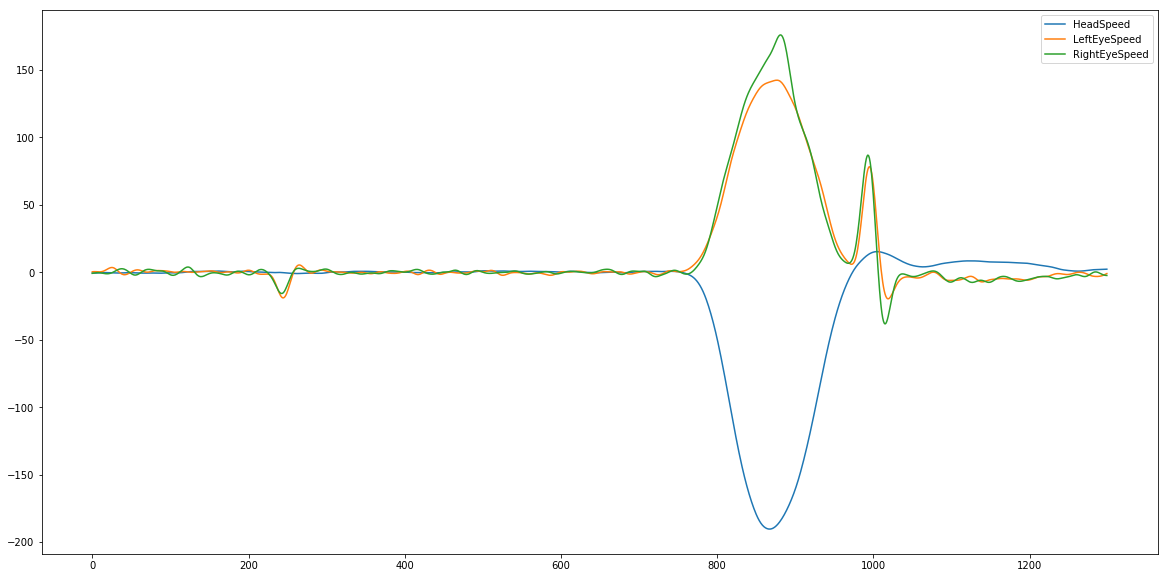

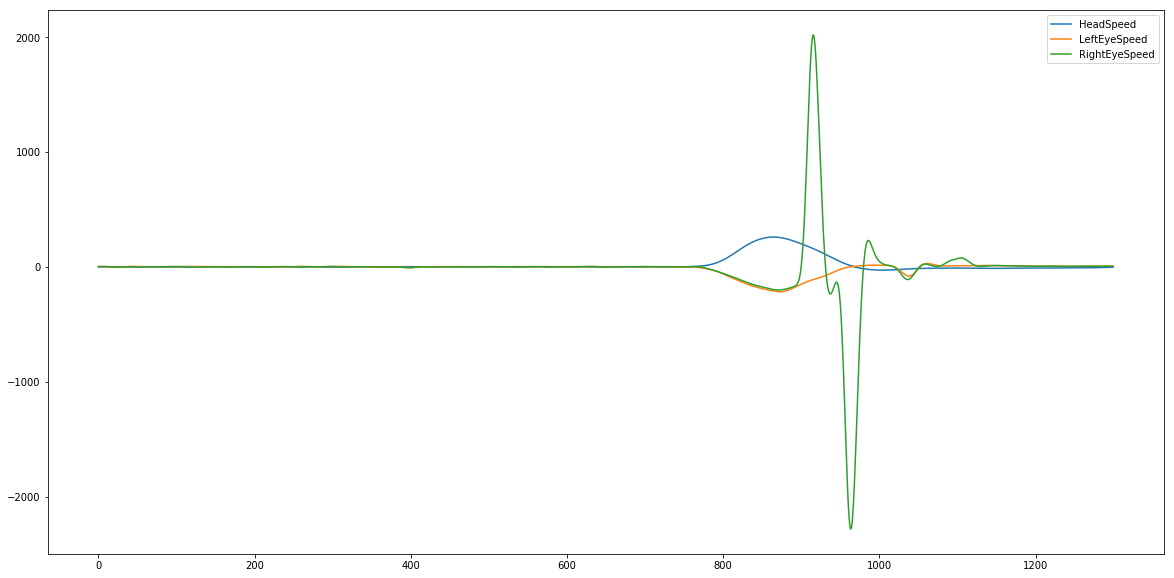

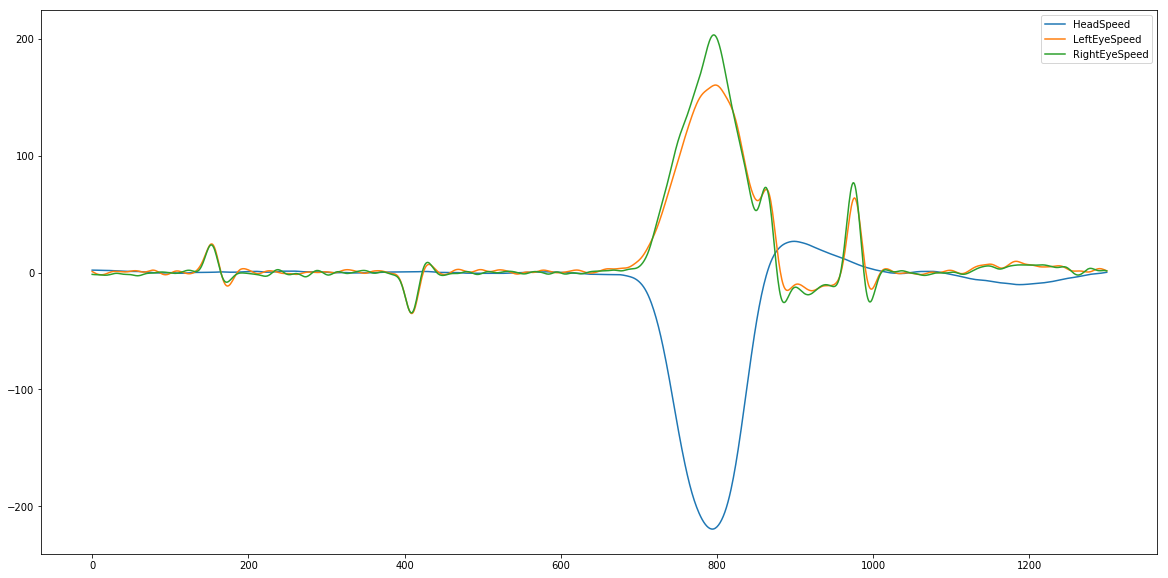

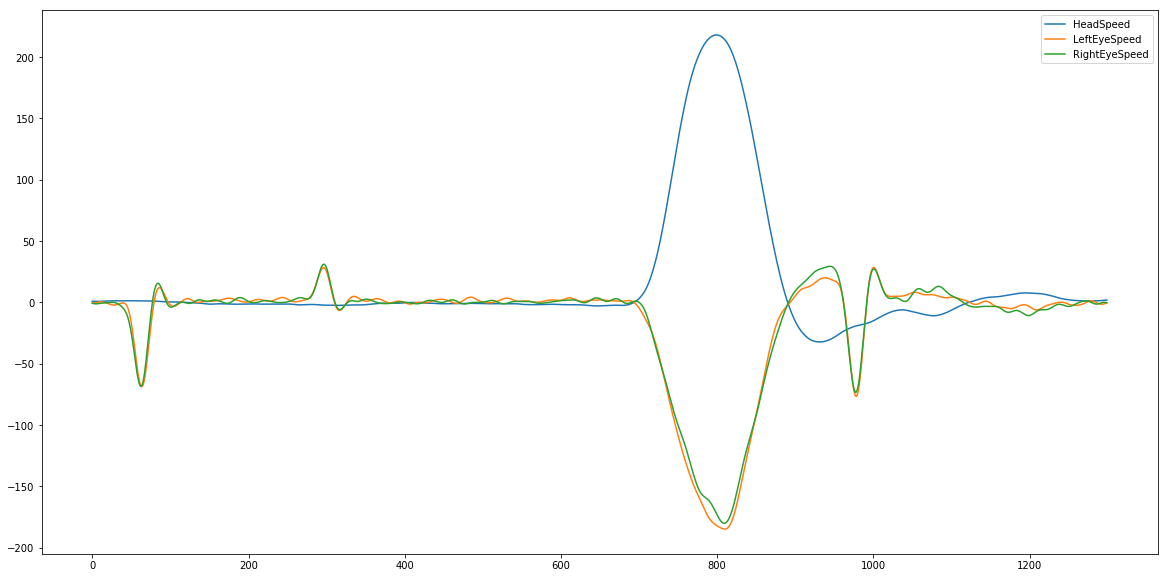

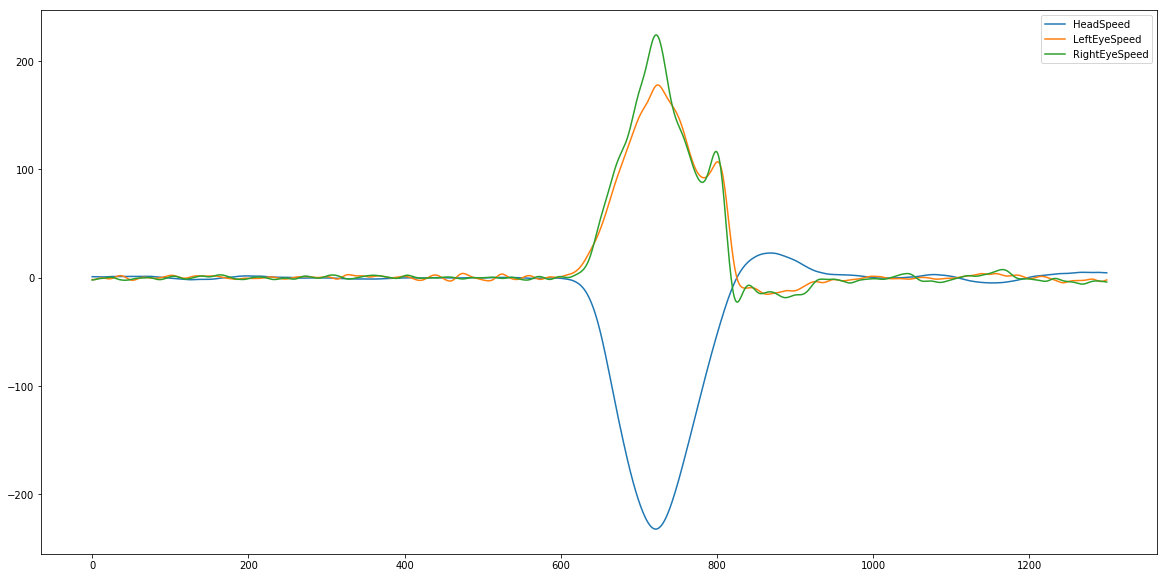

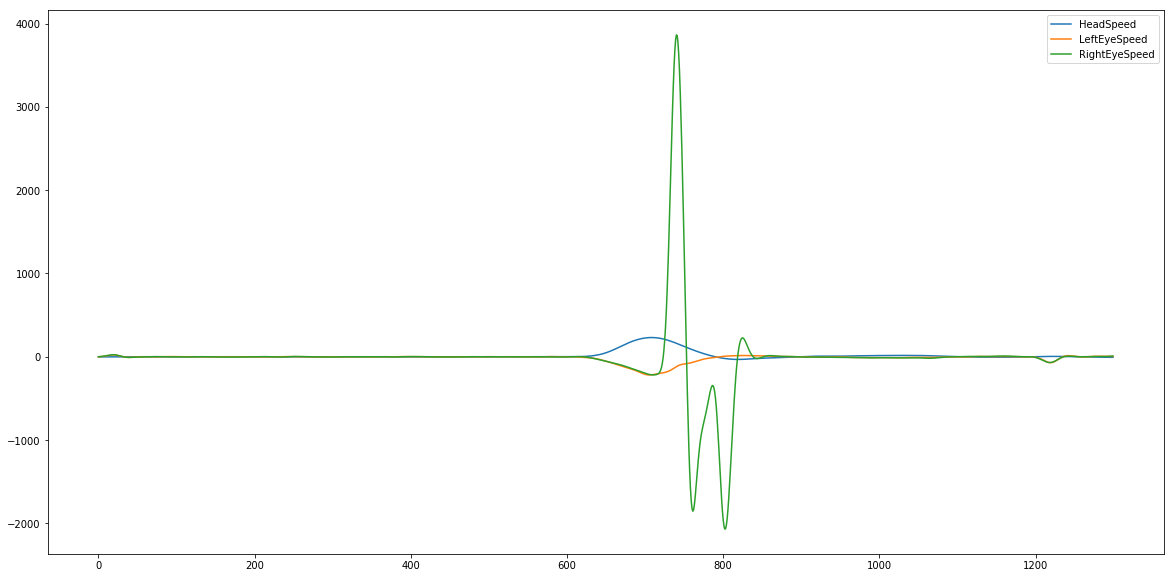

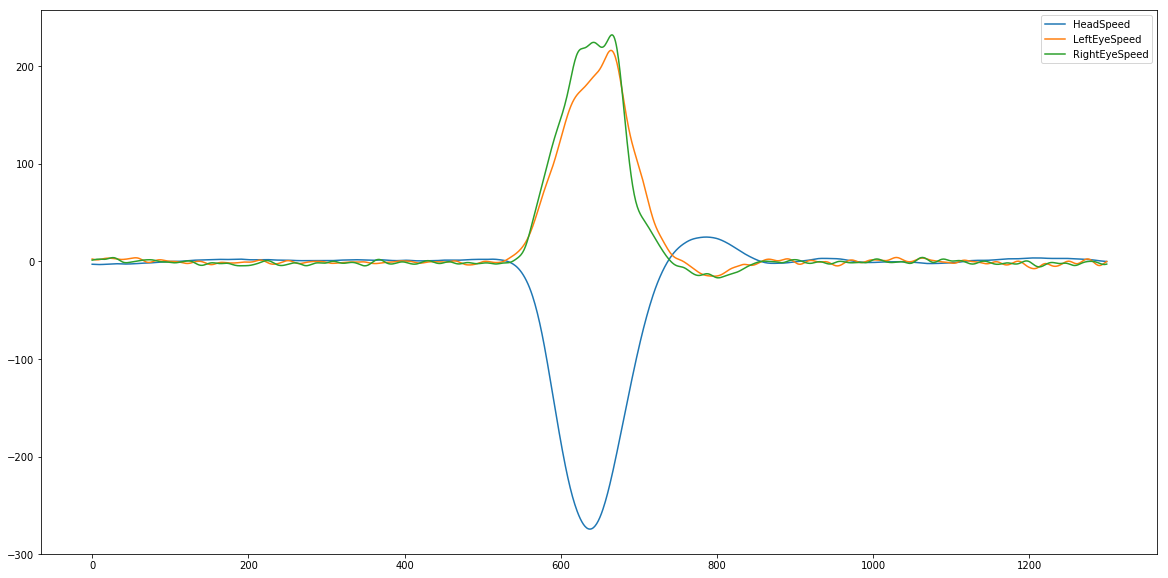

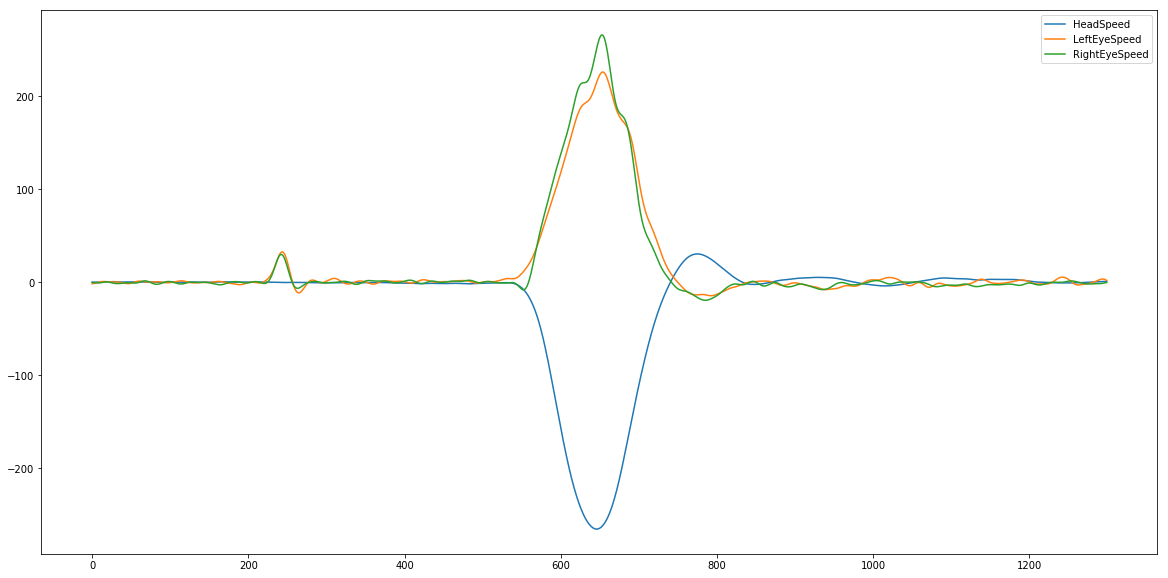

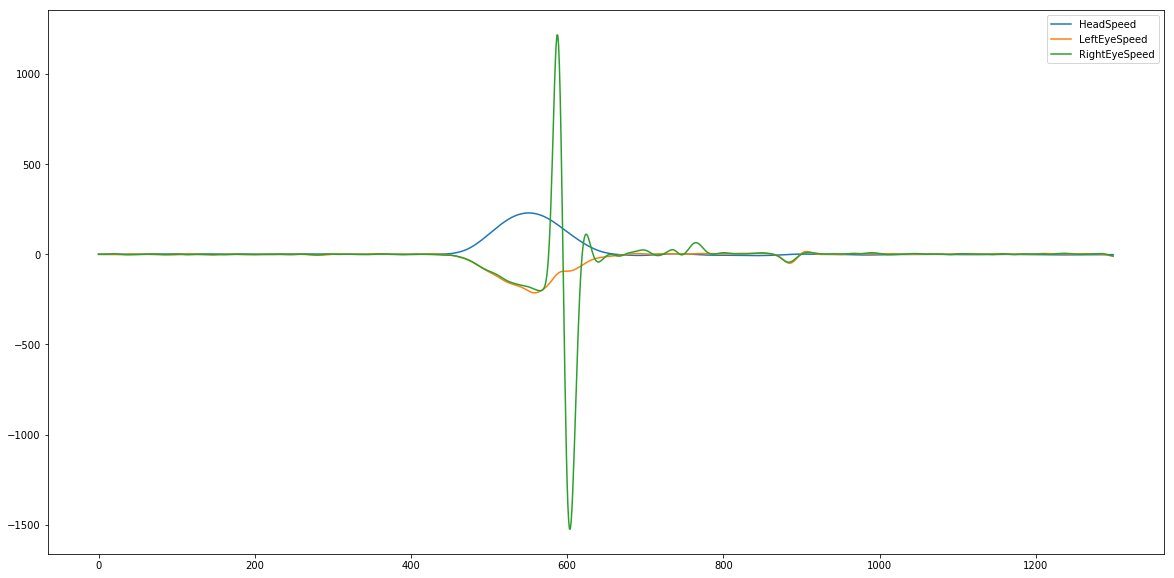

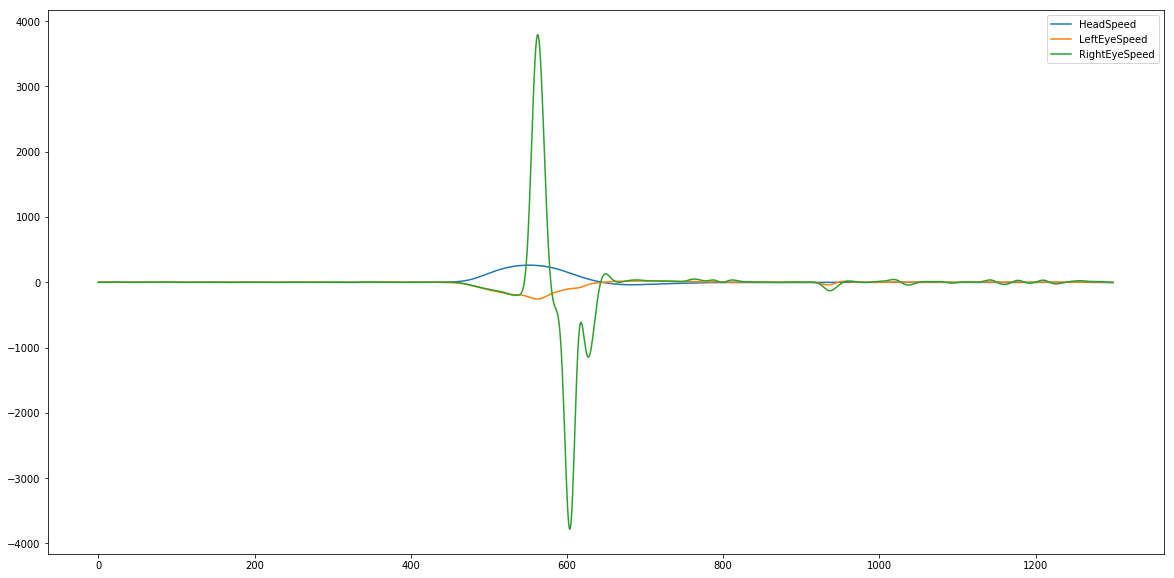

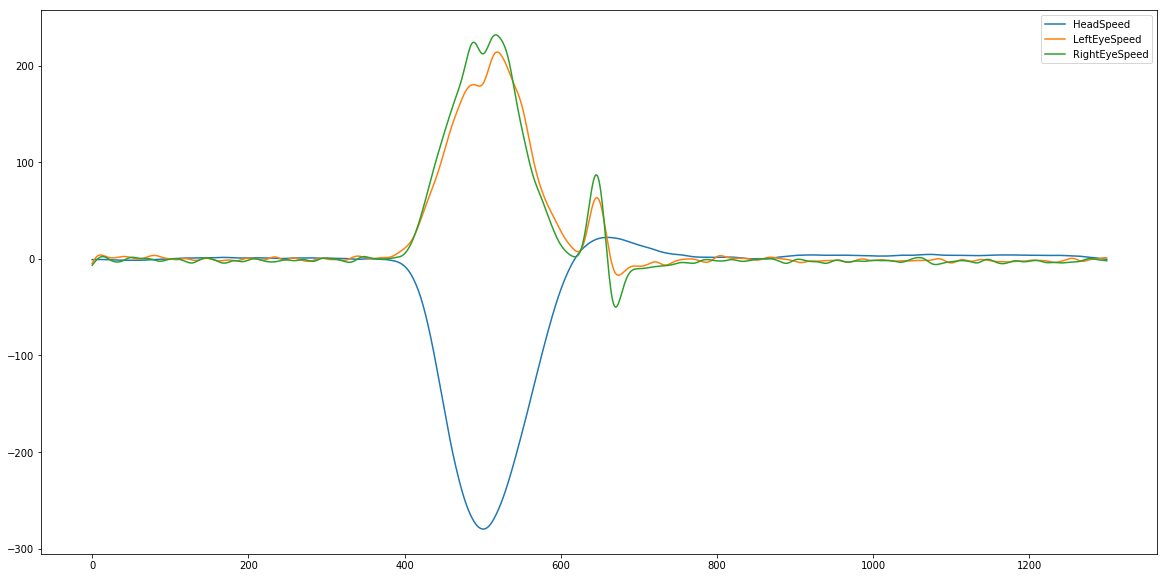

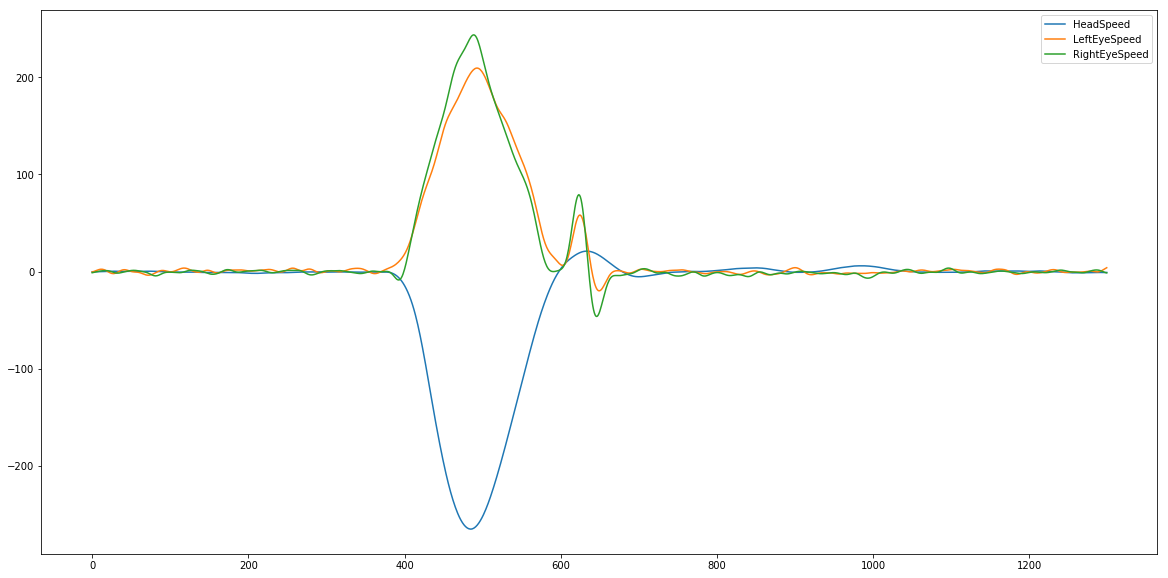

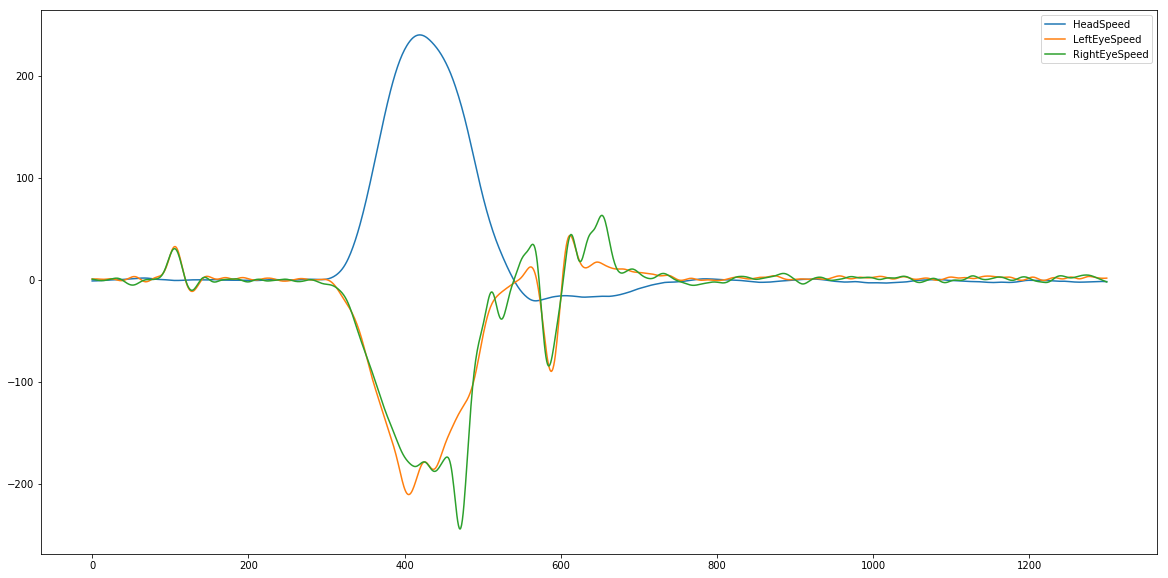

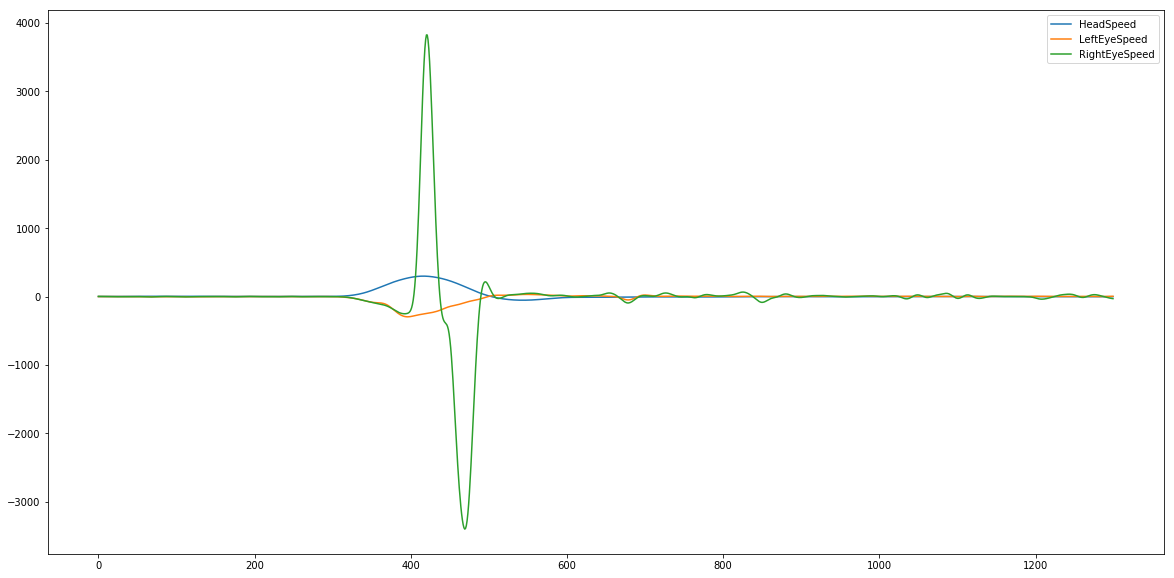

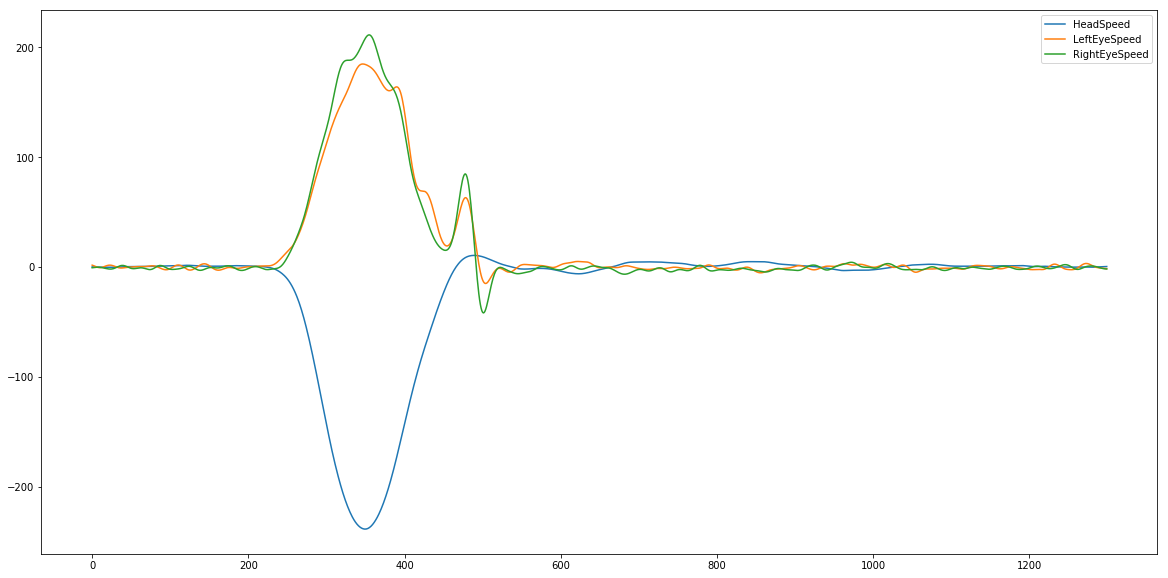

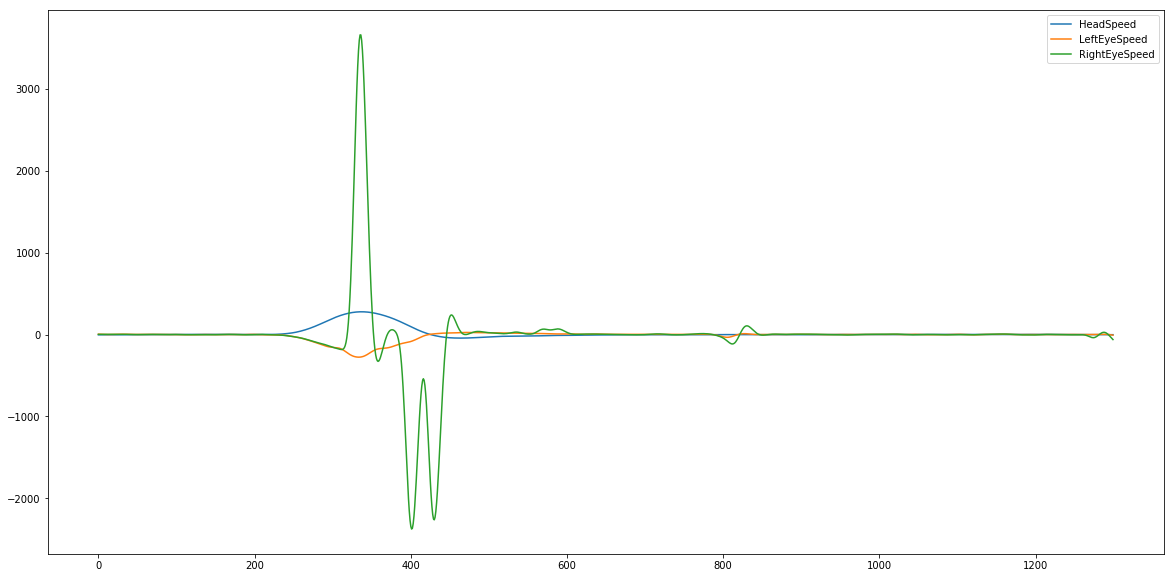

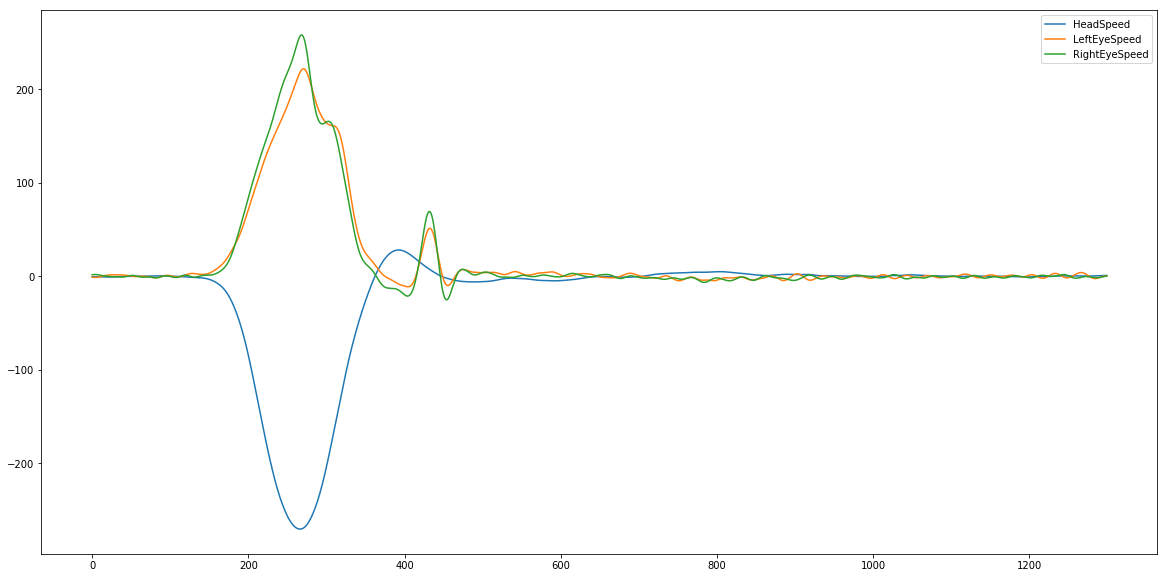

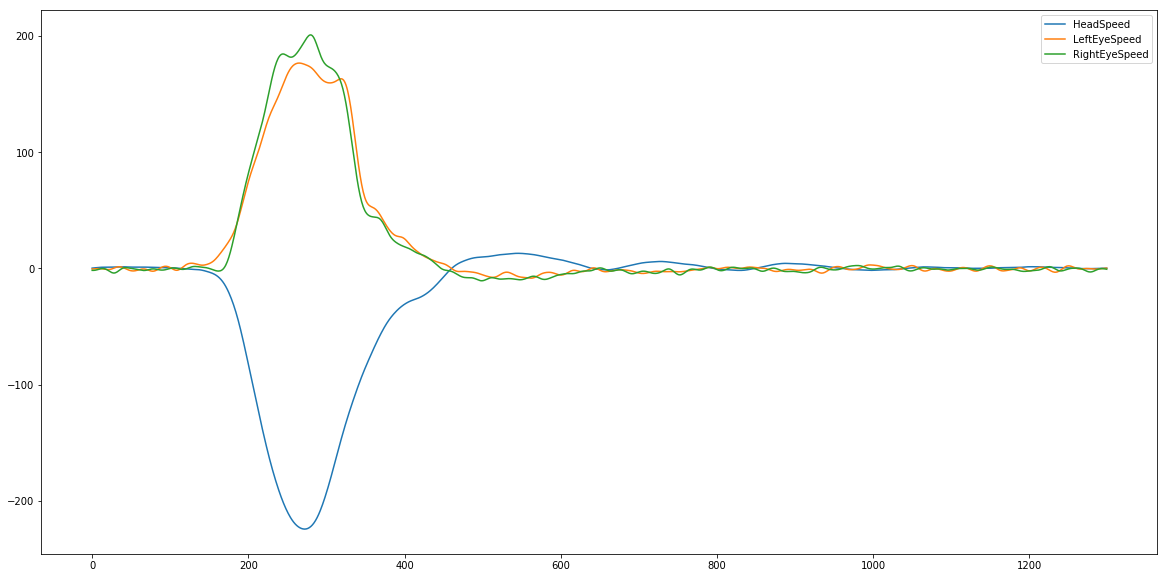

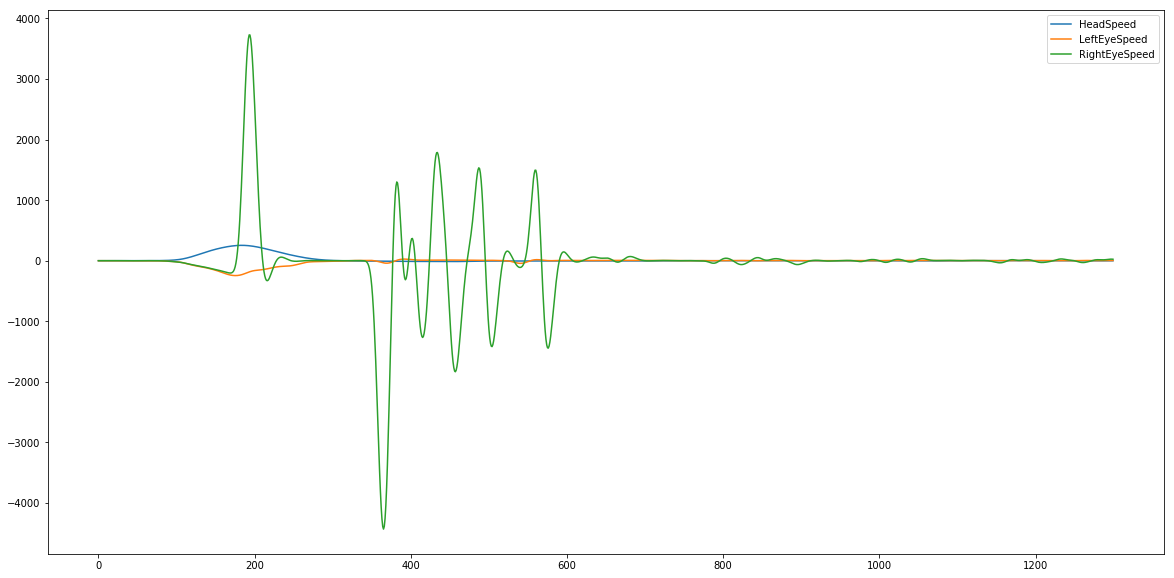

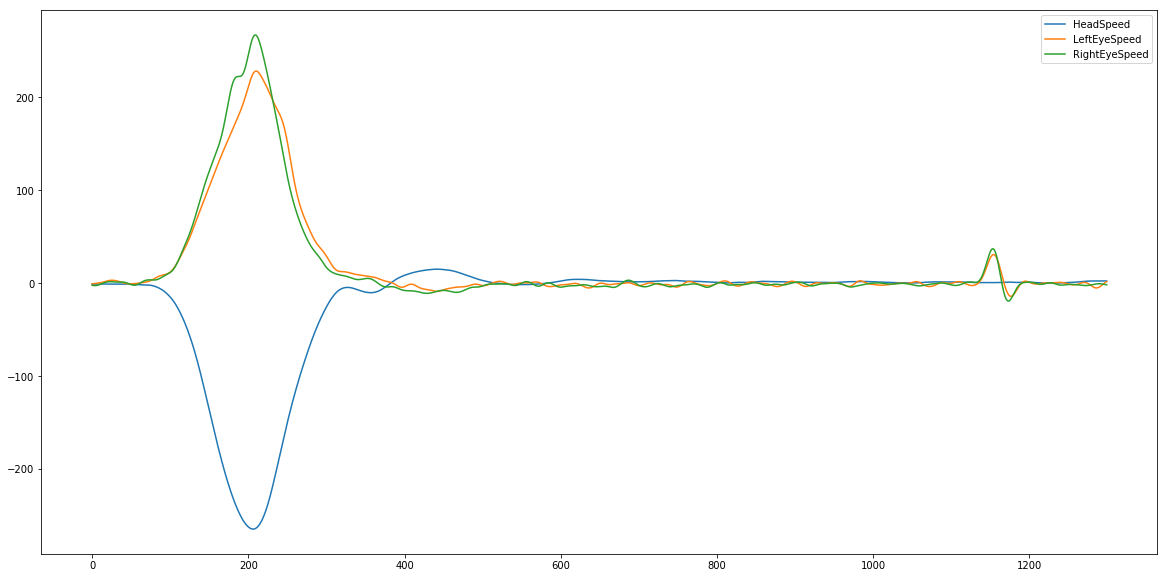

In [15]:
plot_Beyes(section,mat_data)

In [16]:
mat_data.eye_index = 0
mat_data.gaze_cal()

88825


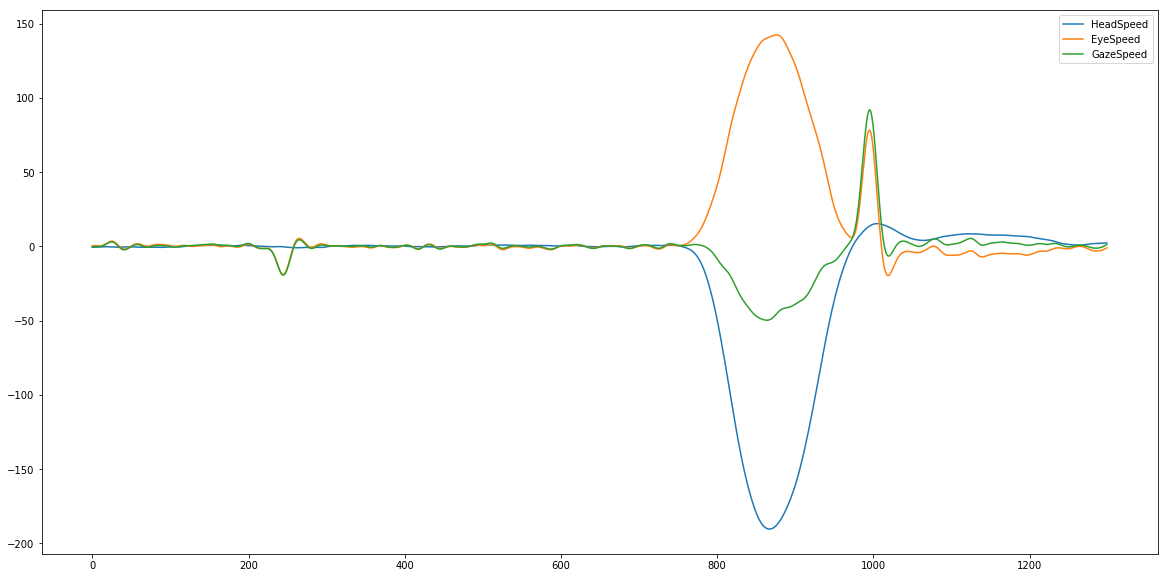

94372


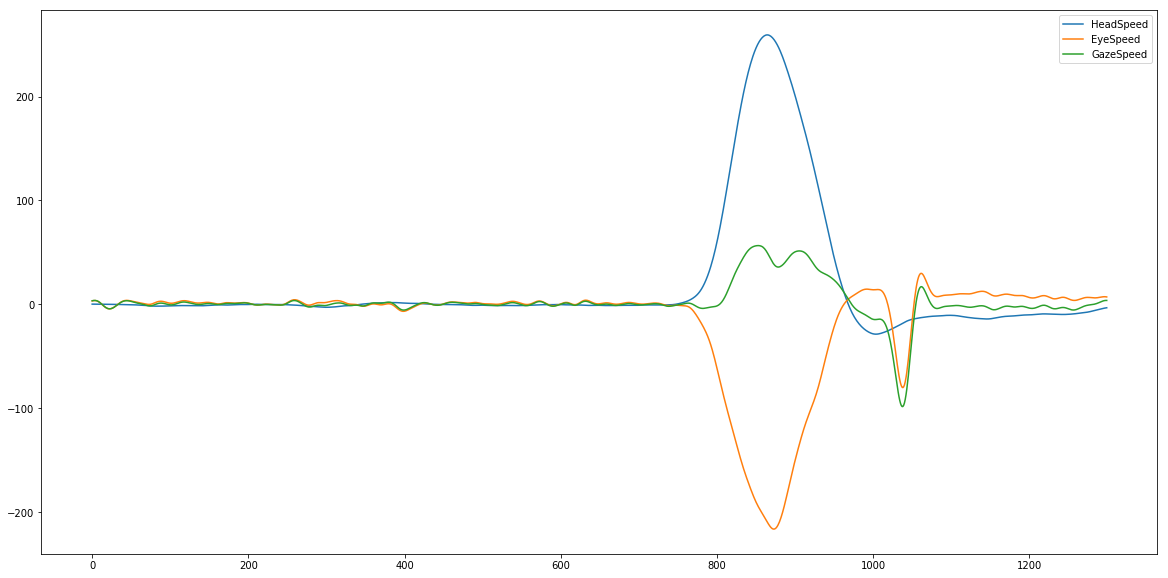

99185


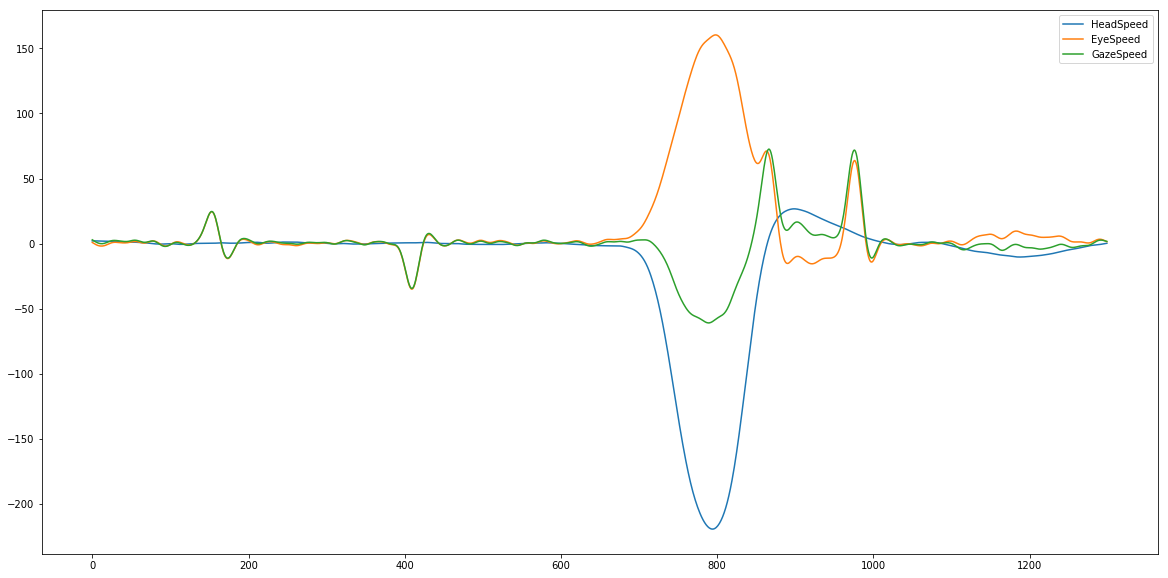

102678


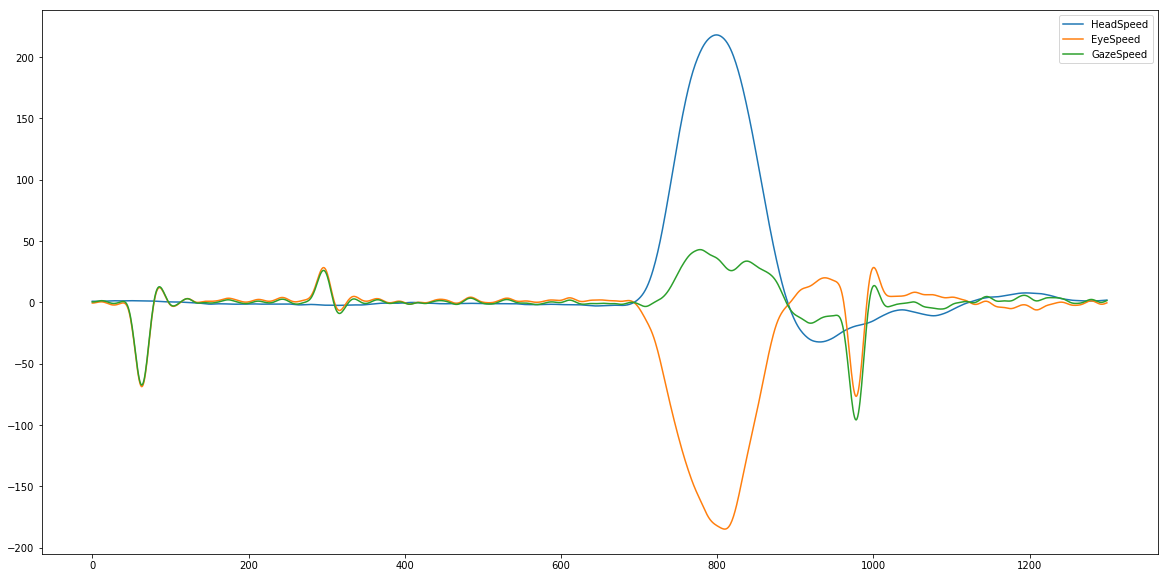

106605


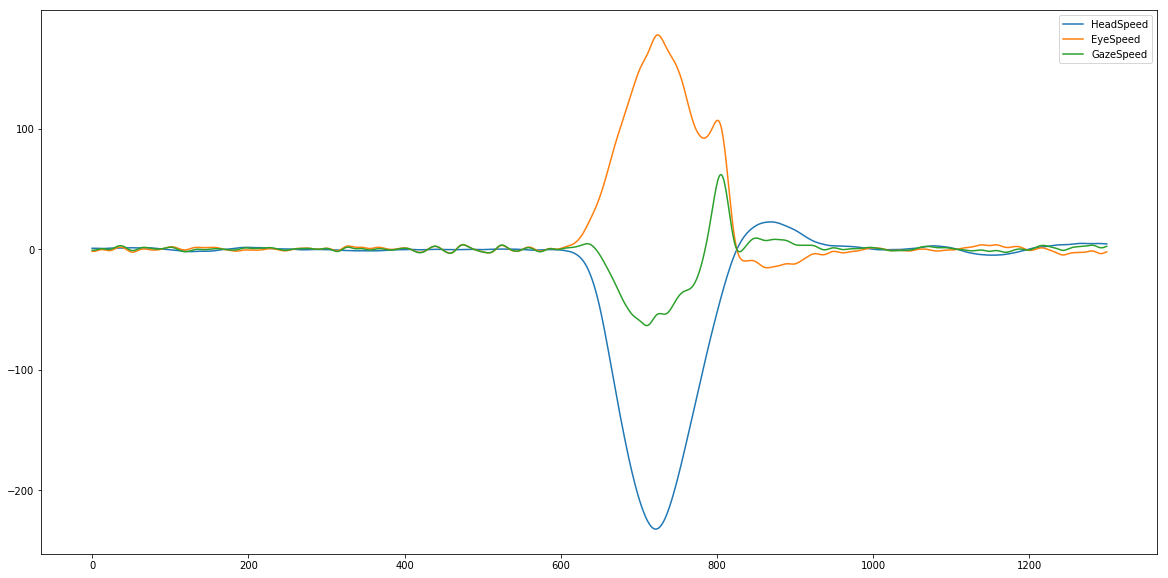

110352


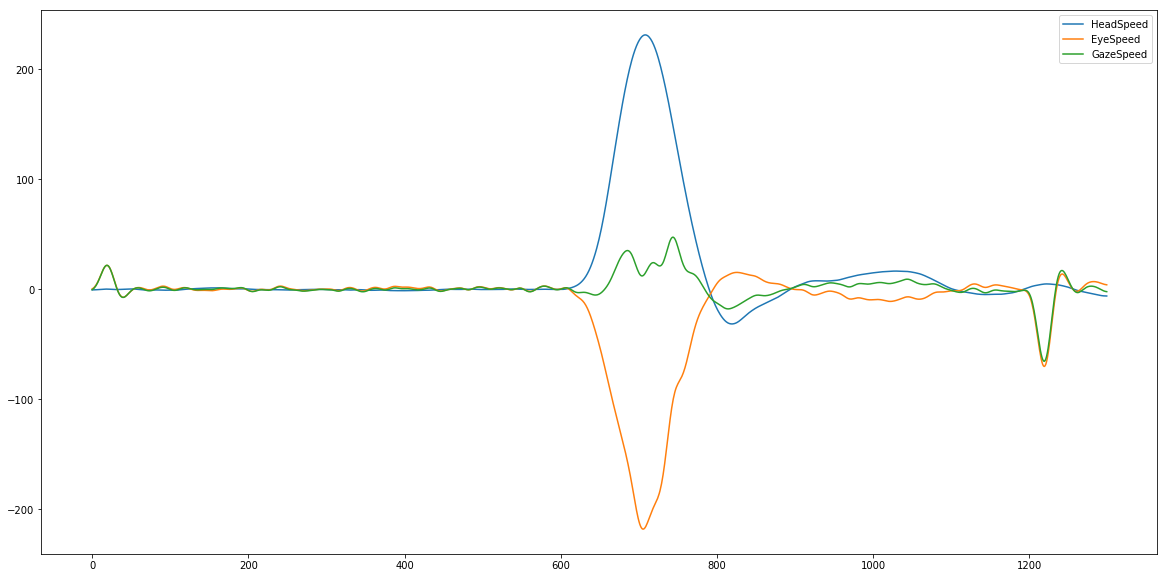

113731


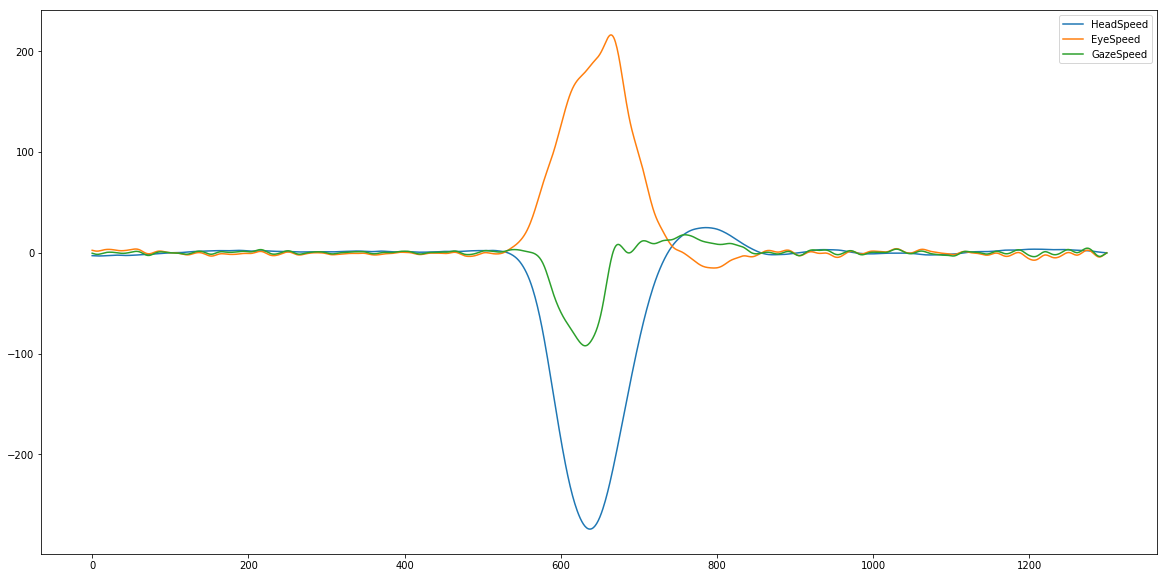

117831


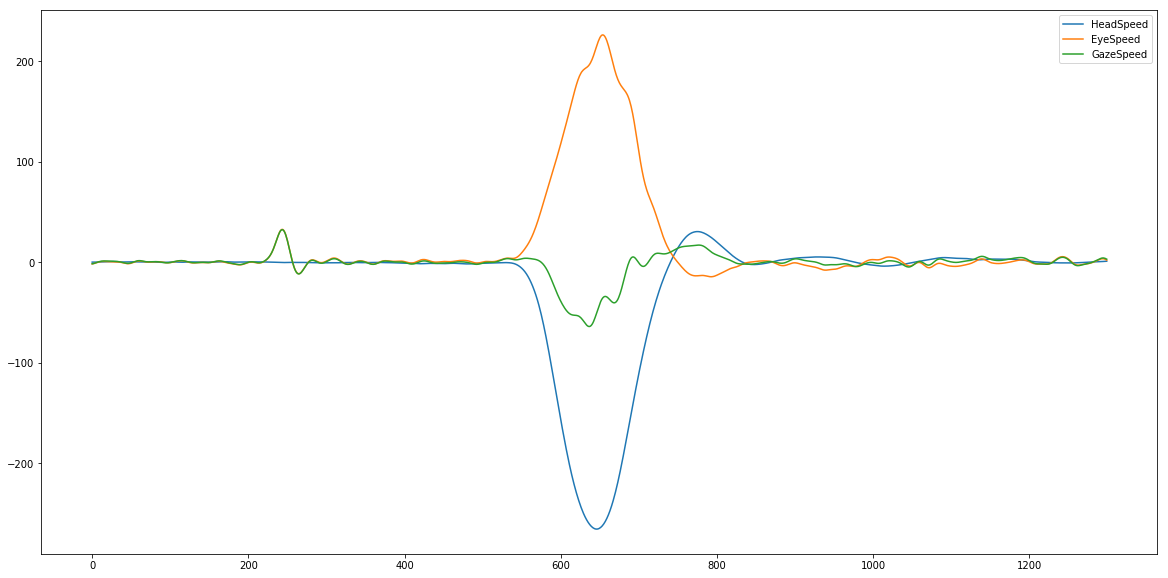

121632


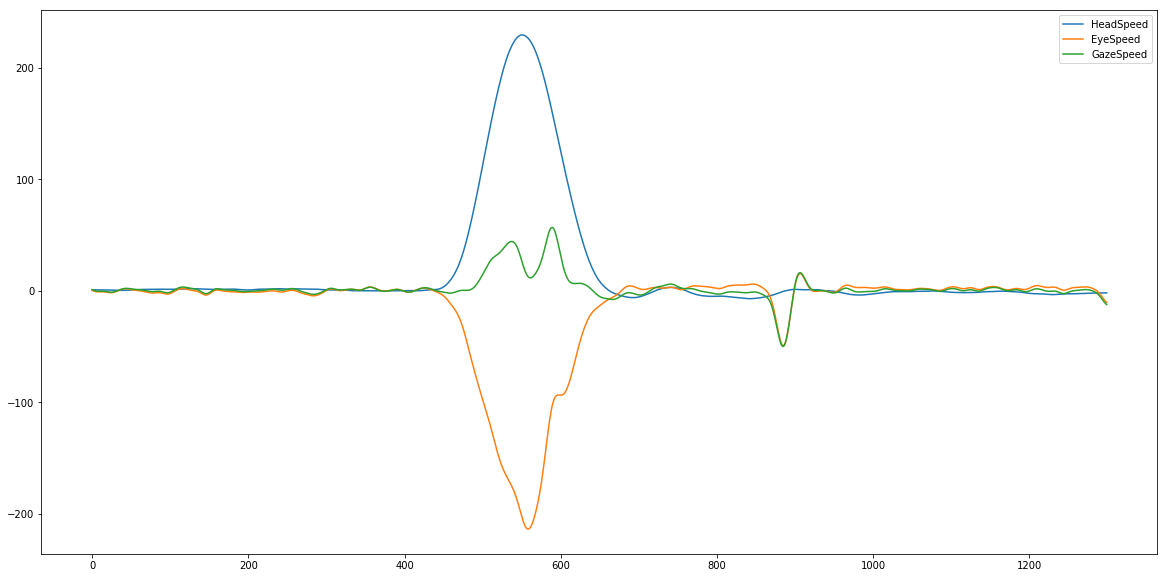

125478


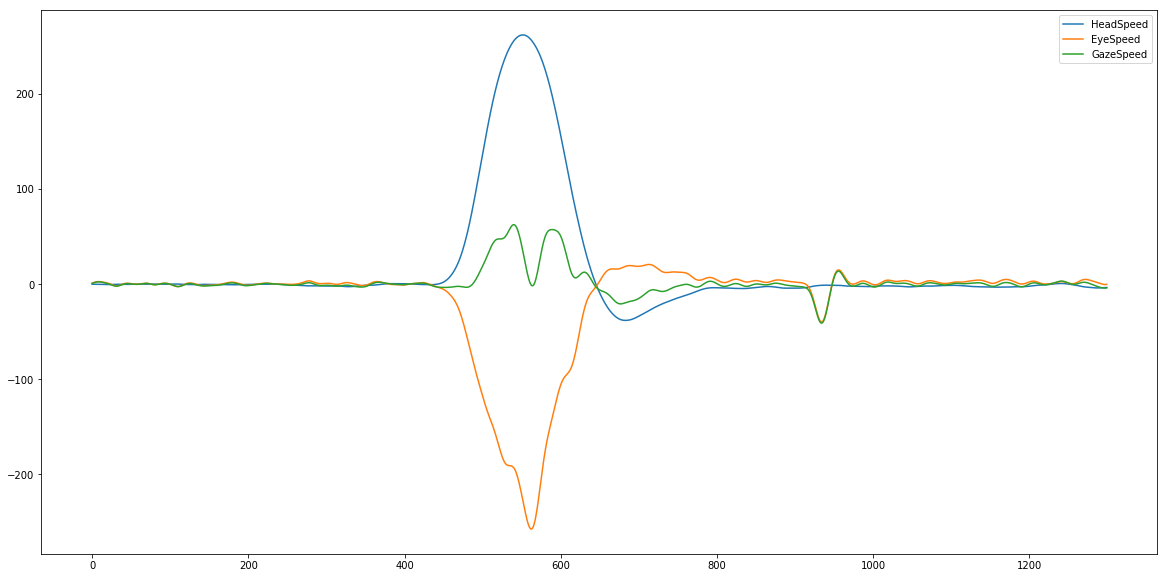

128765


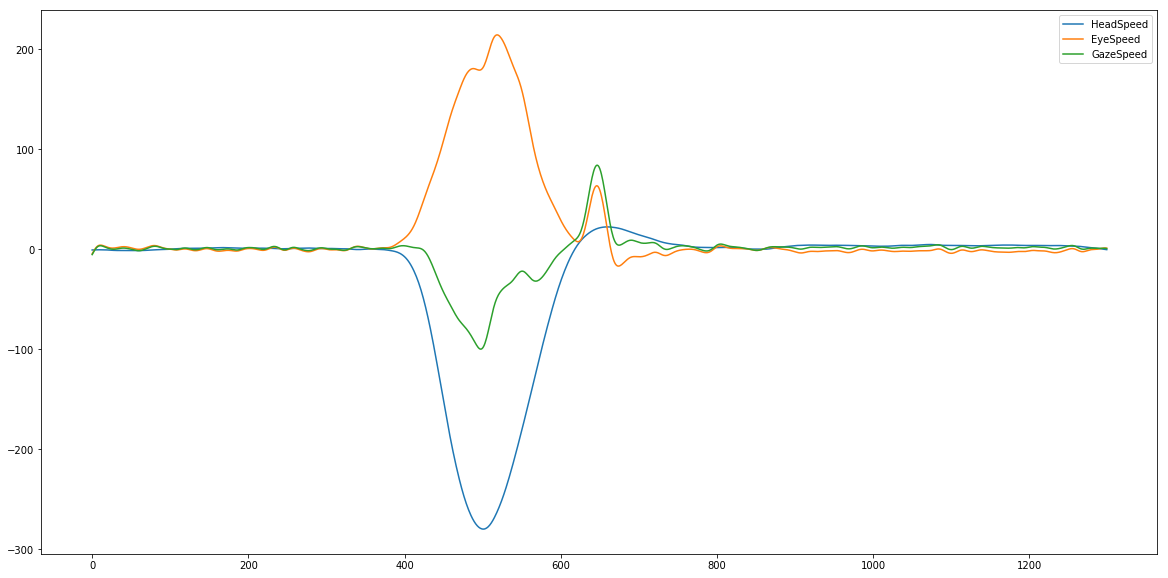

131971


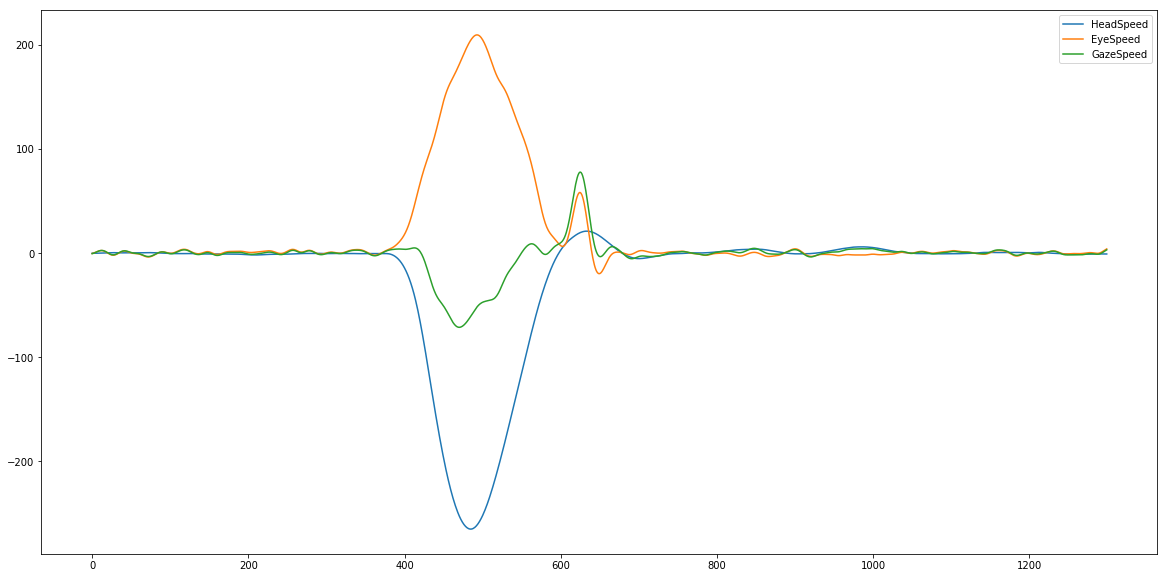

135204


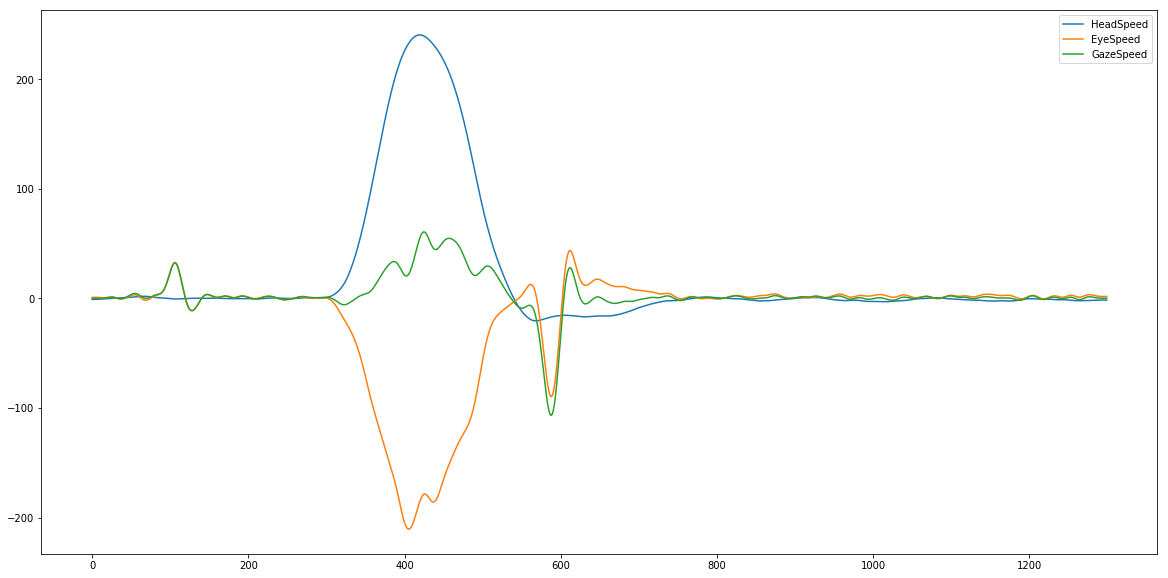

142158


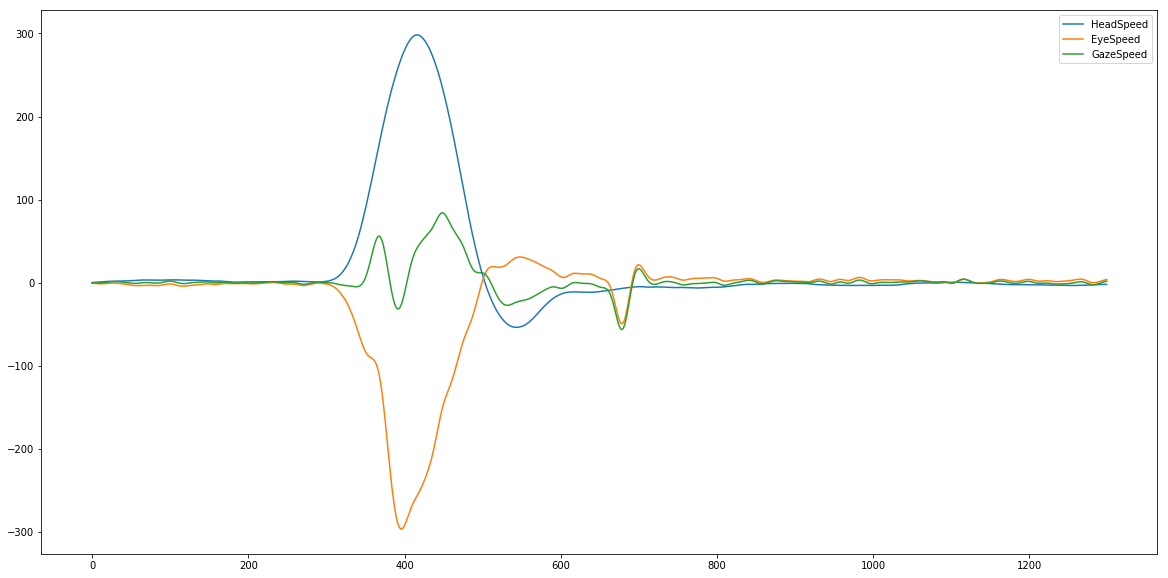

145524


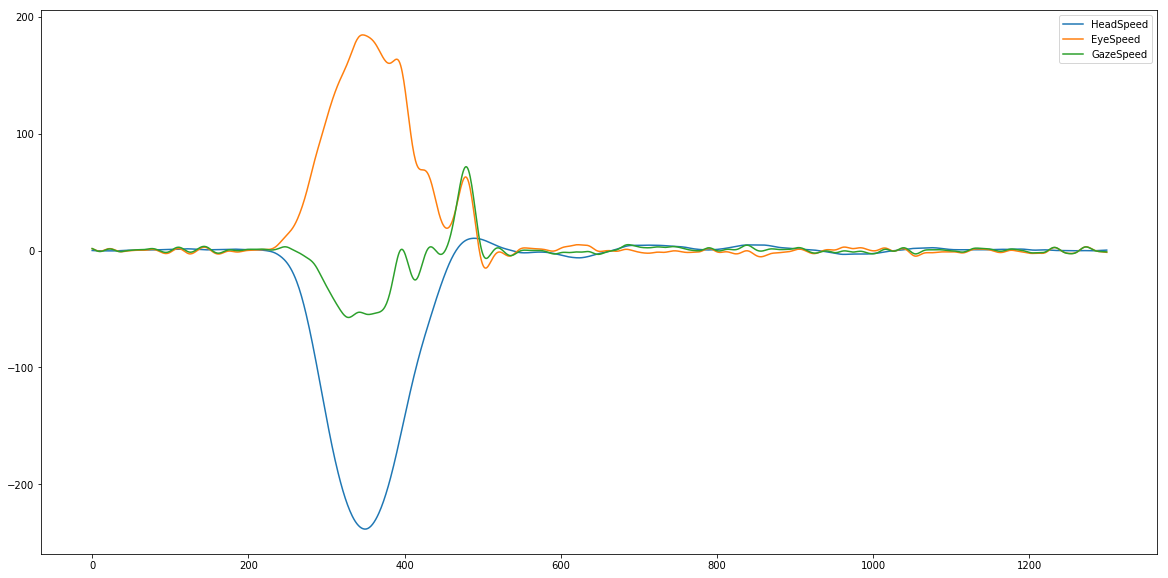

149305


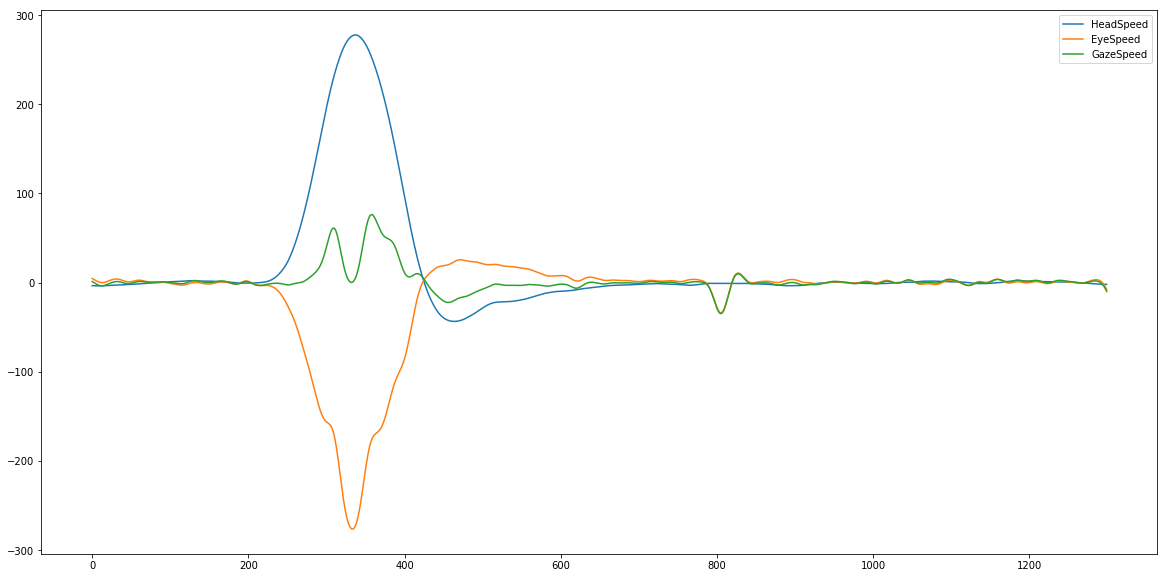

152978


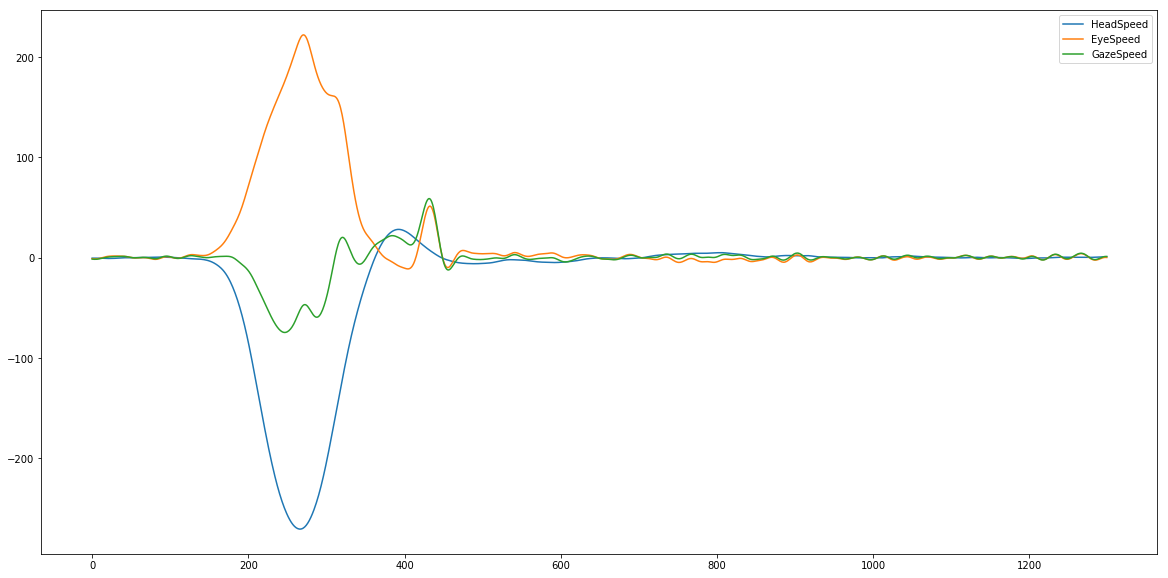

156751


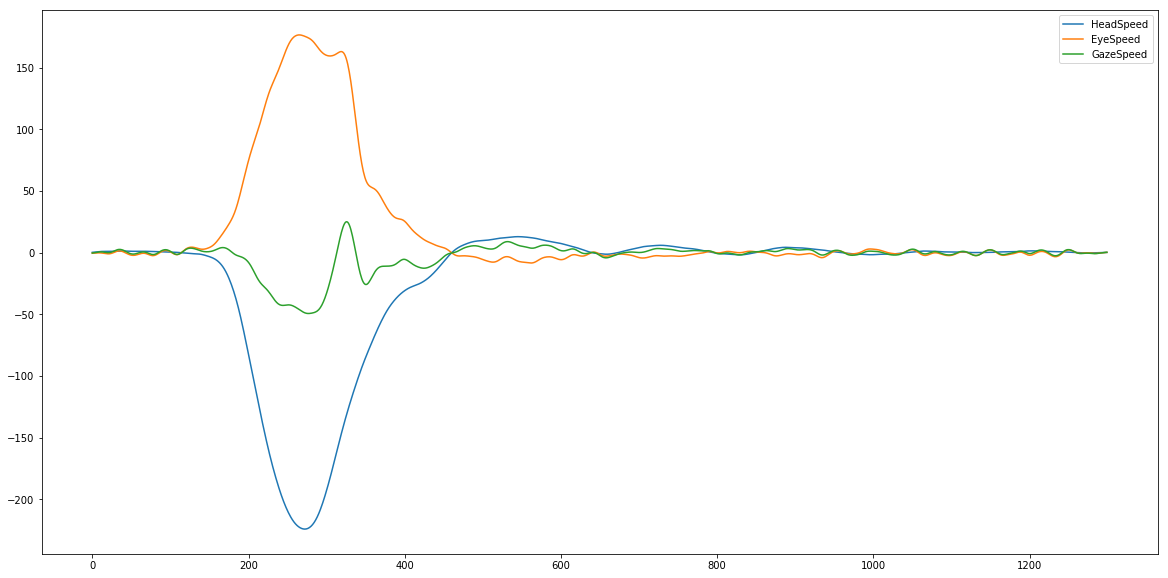

160771


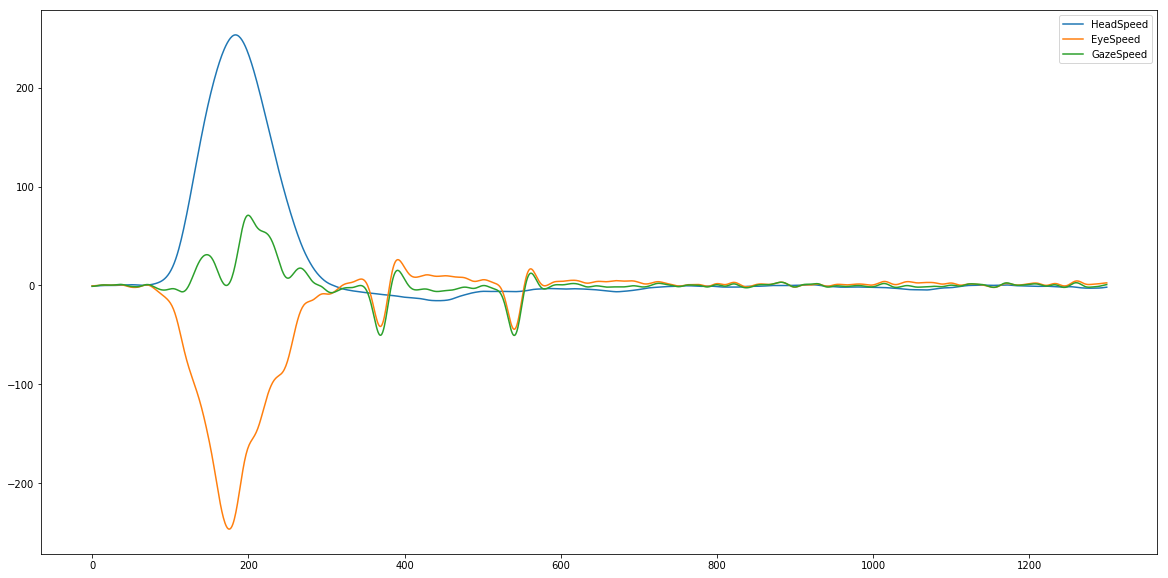

164877


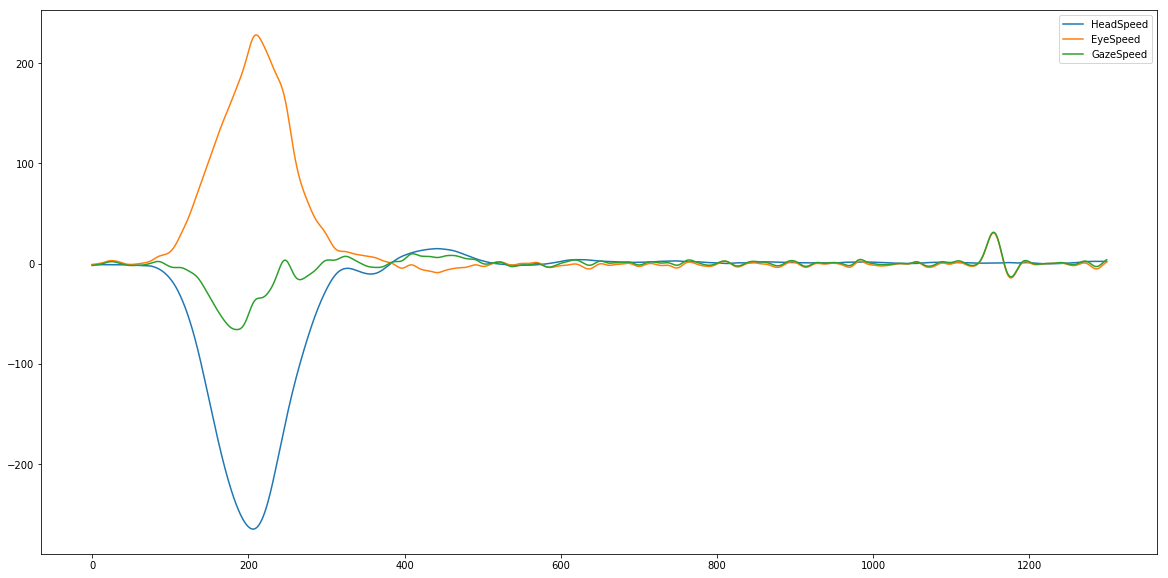

In [17]:
plot_total(section,mat_data)

89522


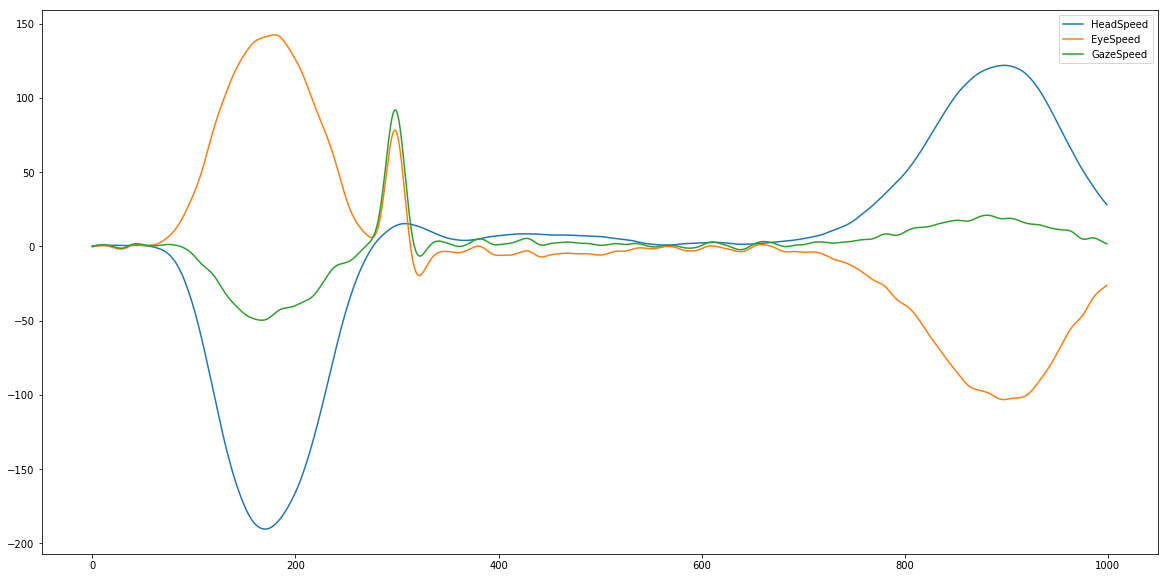

95066


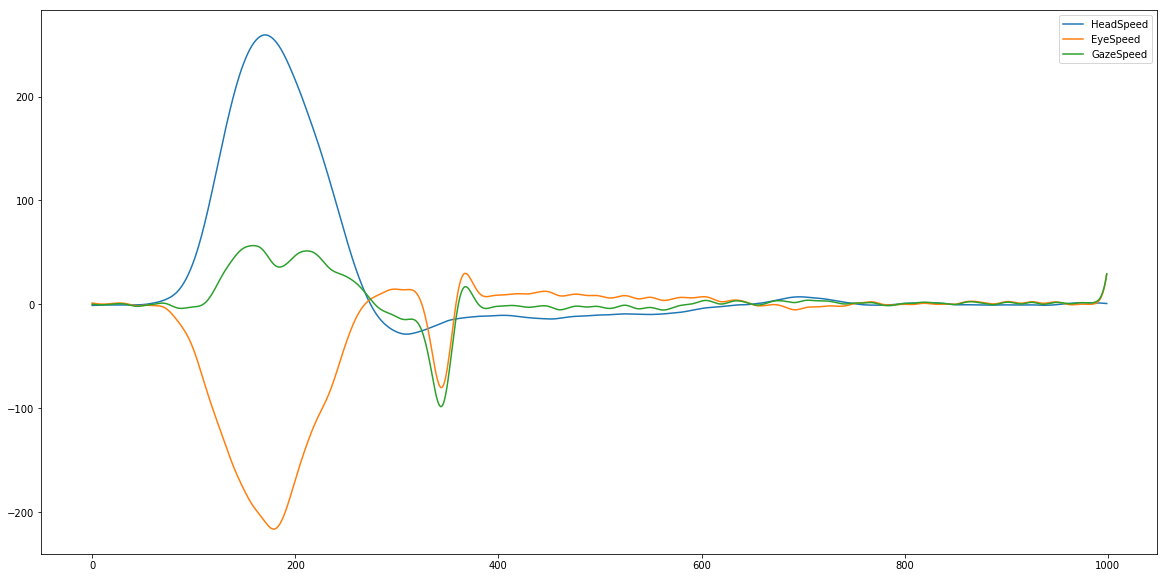

99808


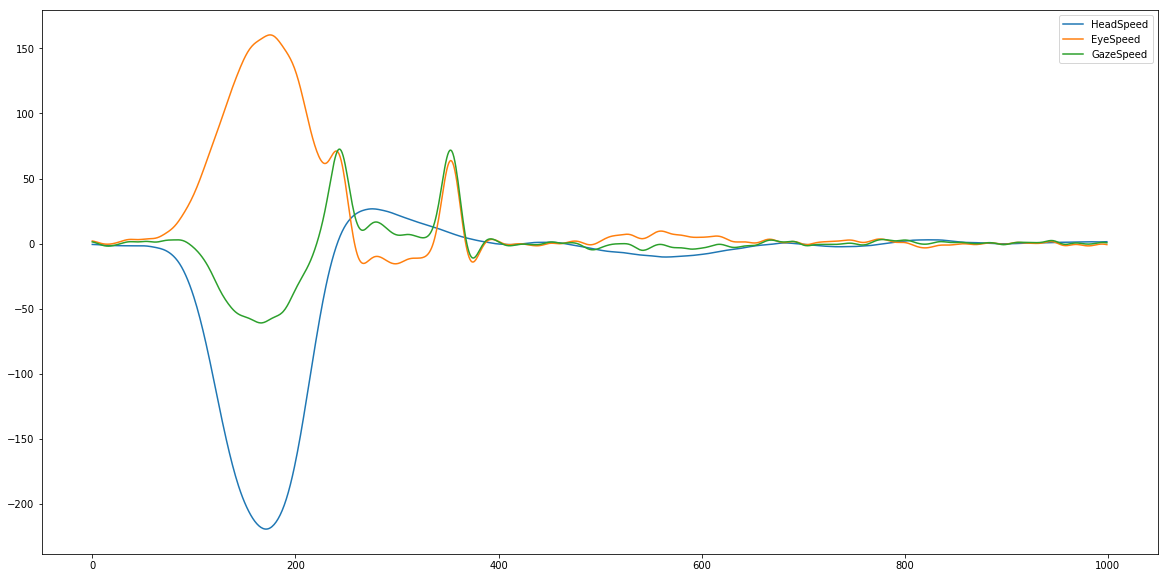

103302


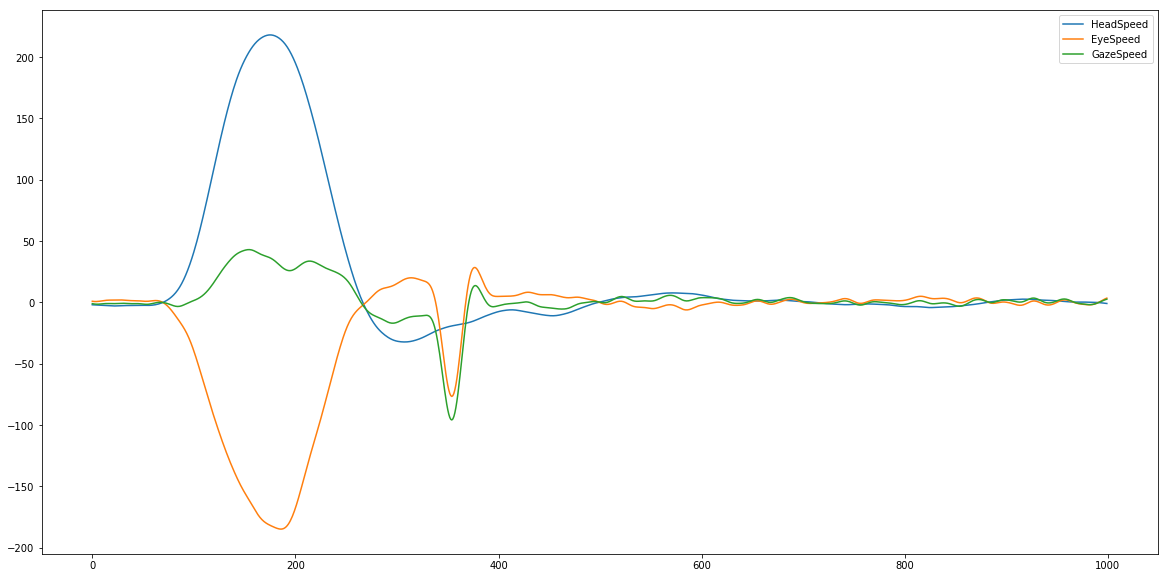

107152


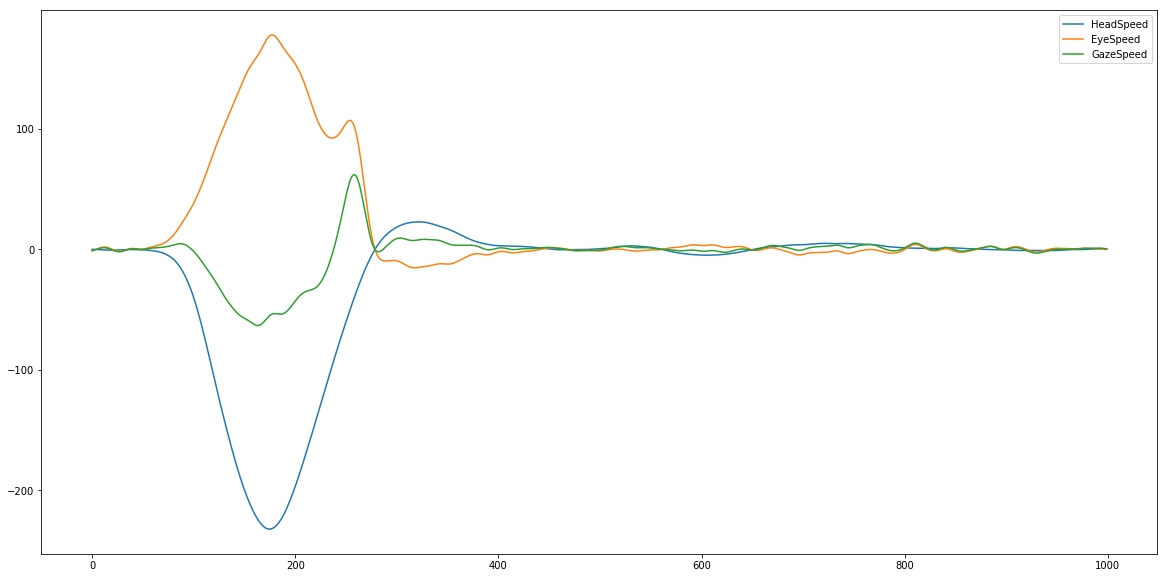

110900


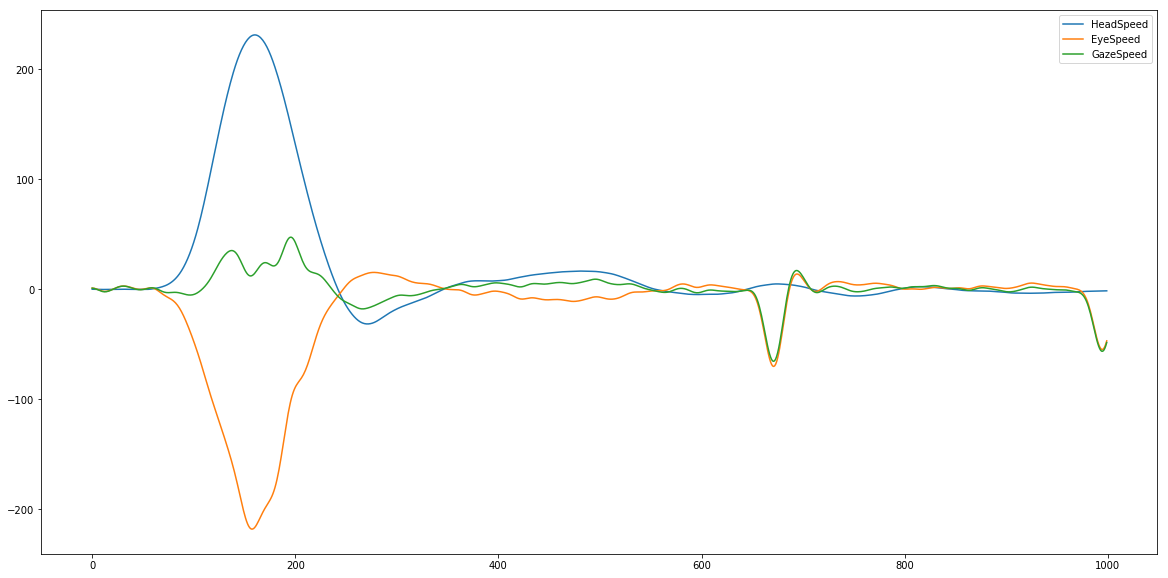

114197


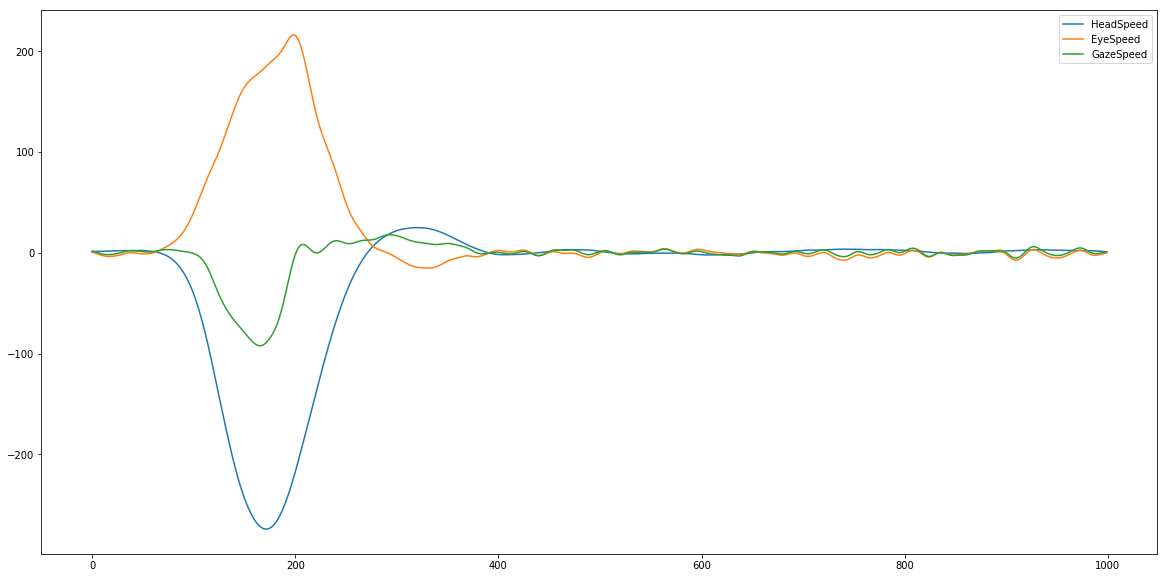

118302


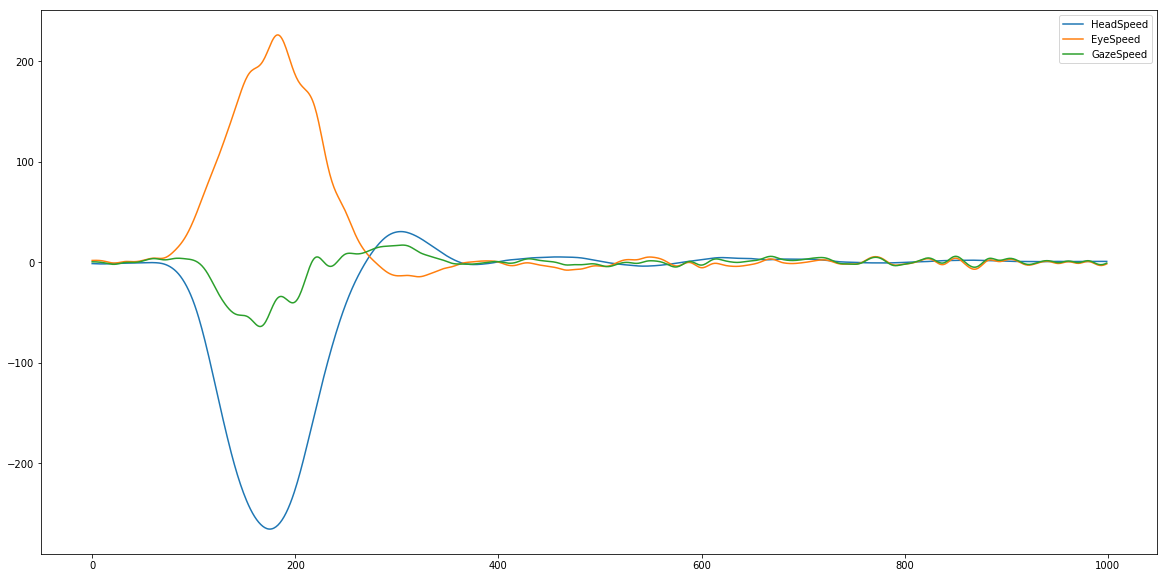

122010


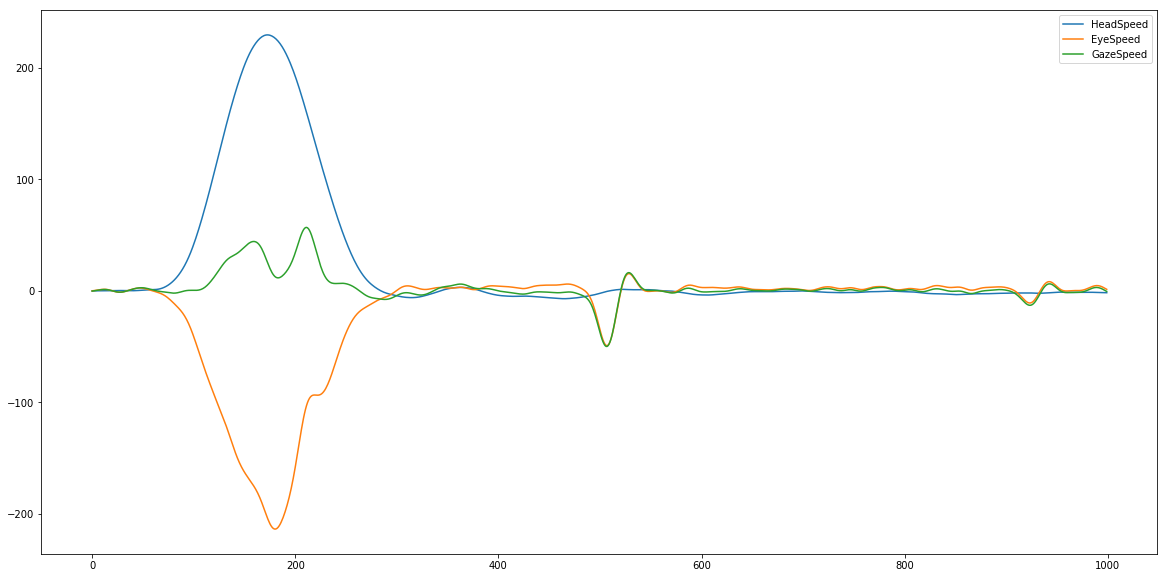

125854


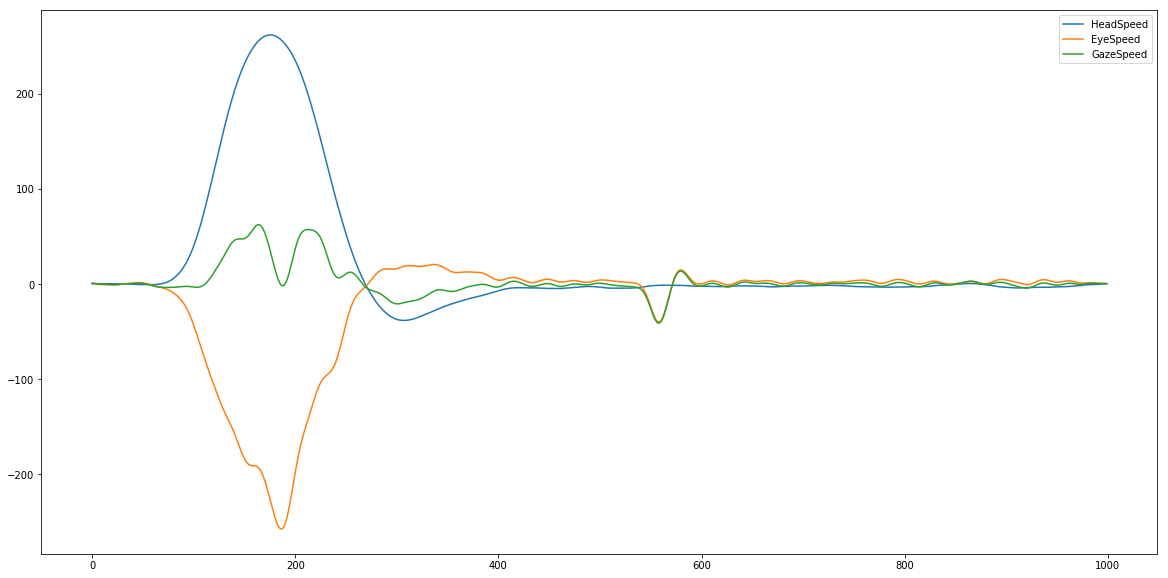

129086


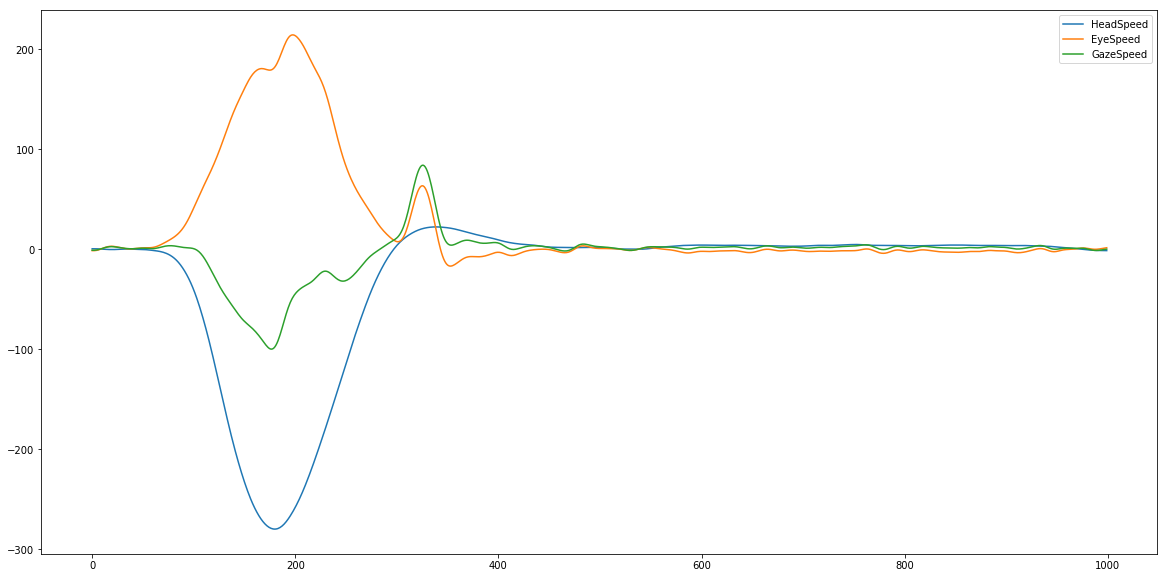

132284


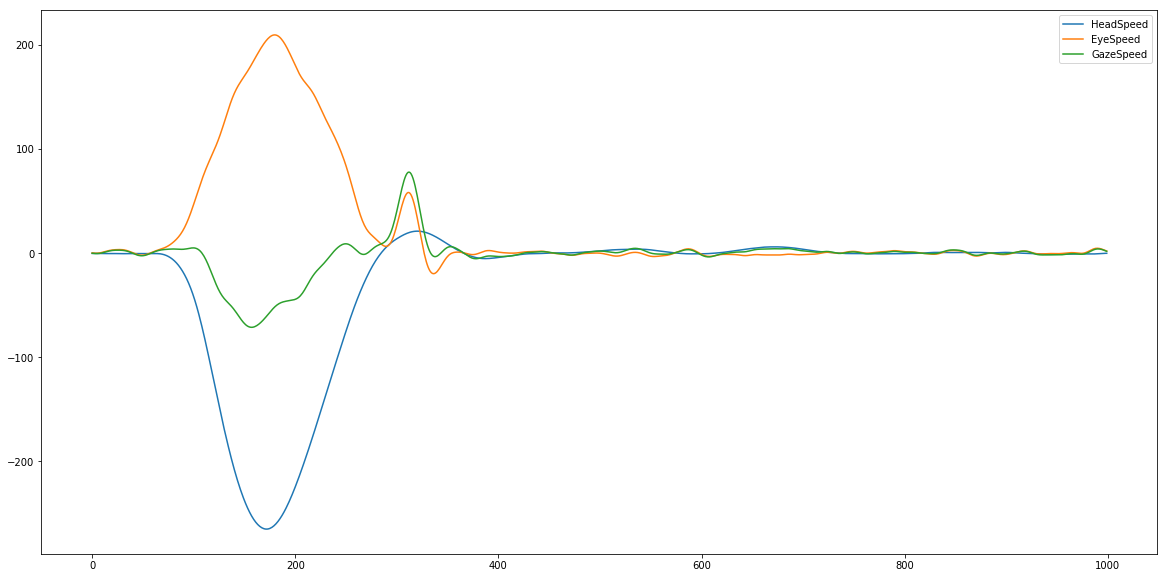

135442


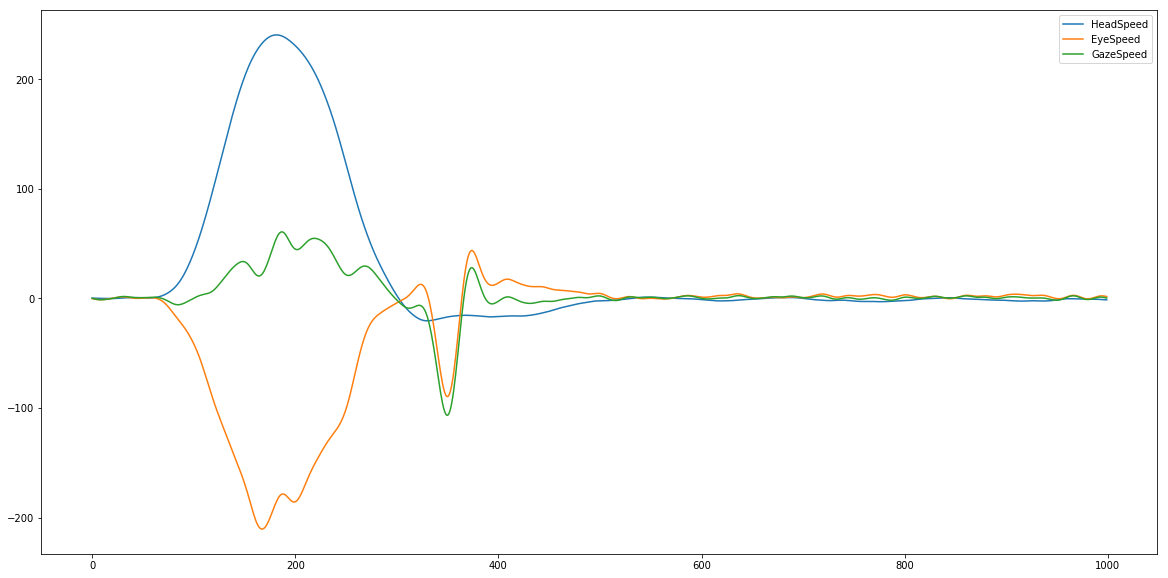

142394


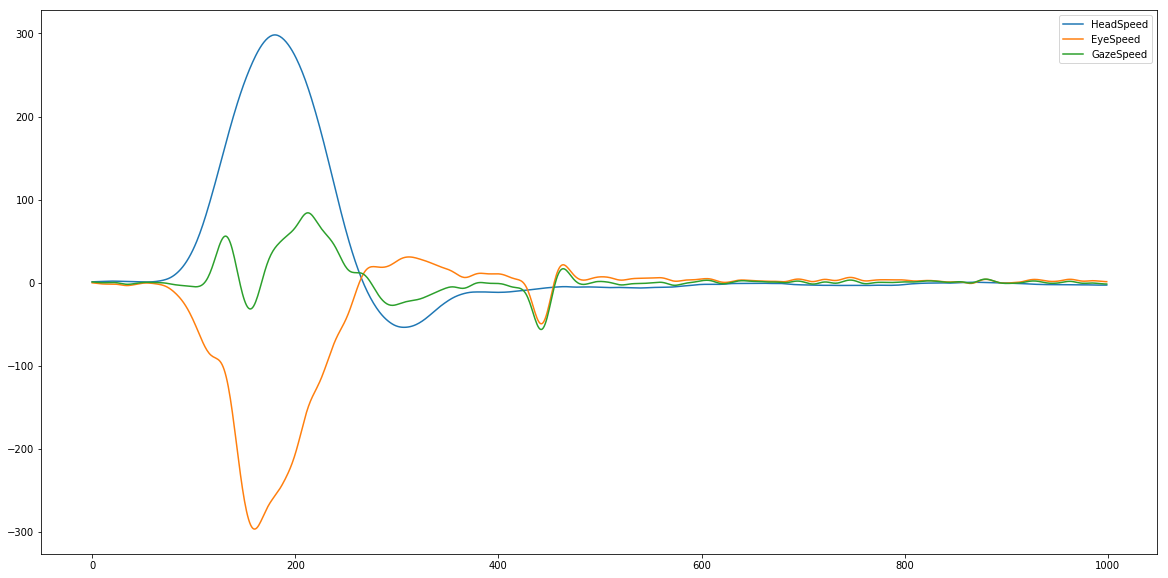

145693


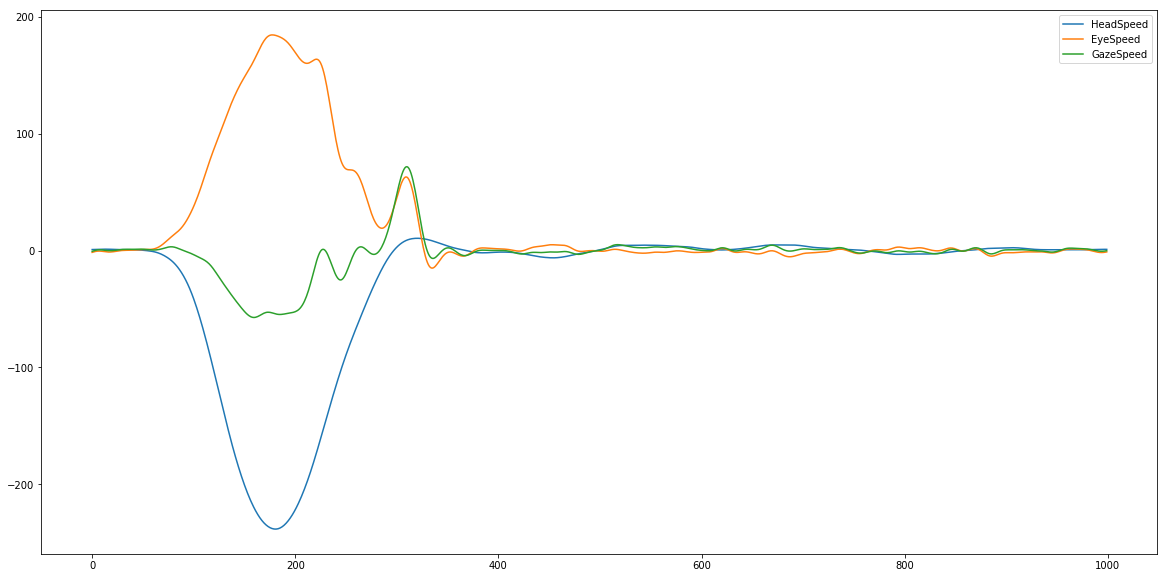

149464


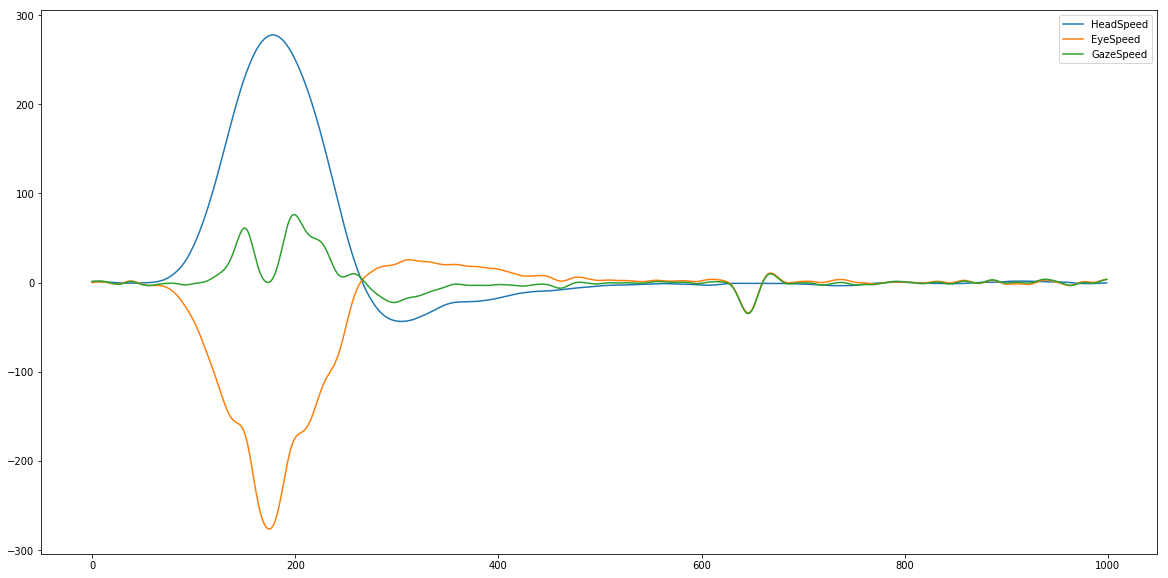

153064


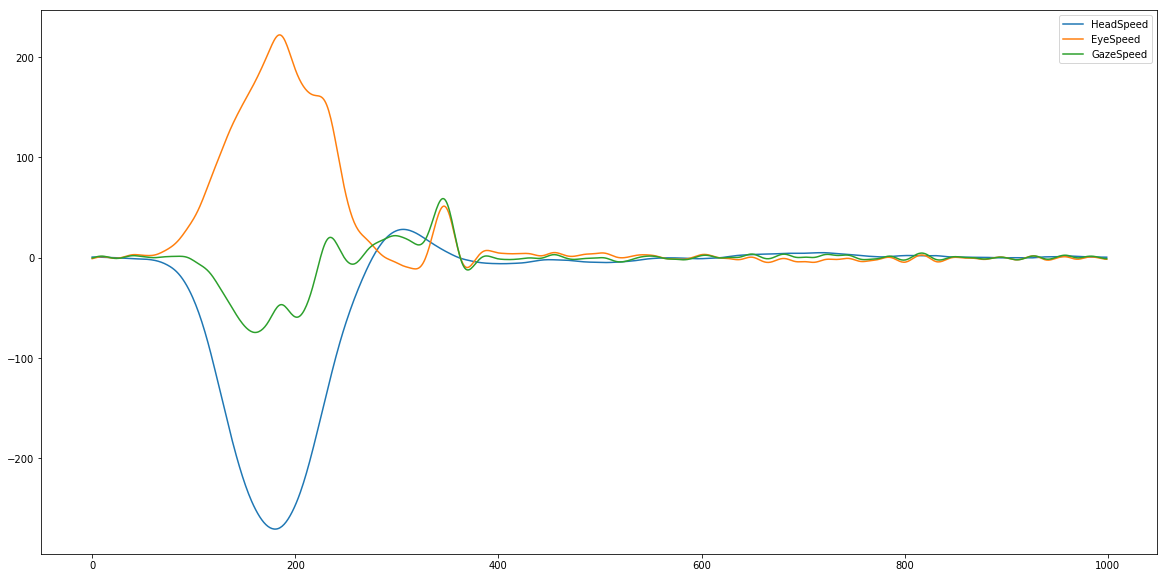

156837


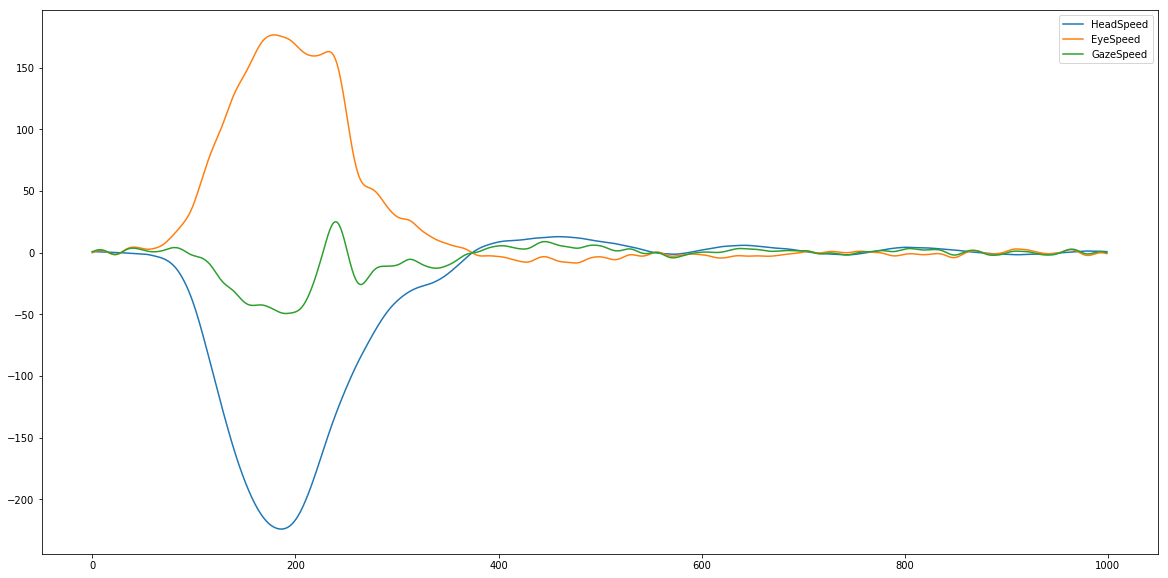

160783


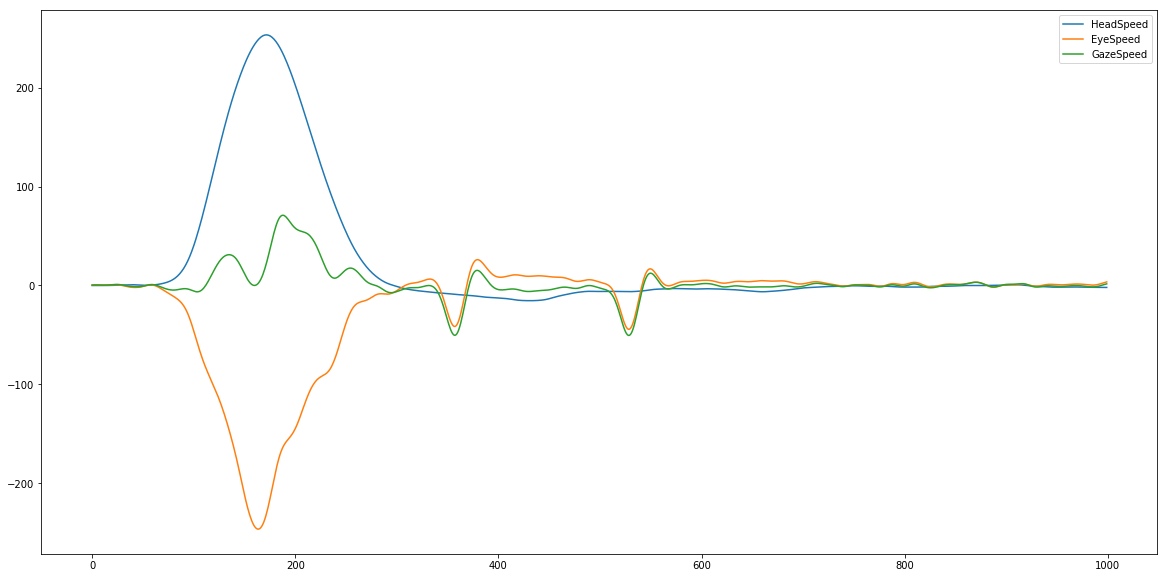

164895


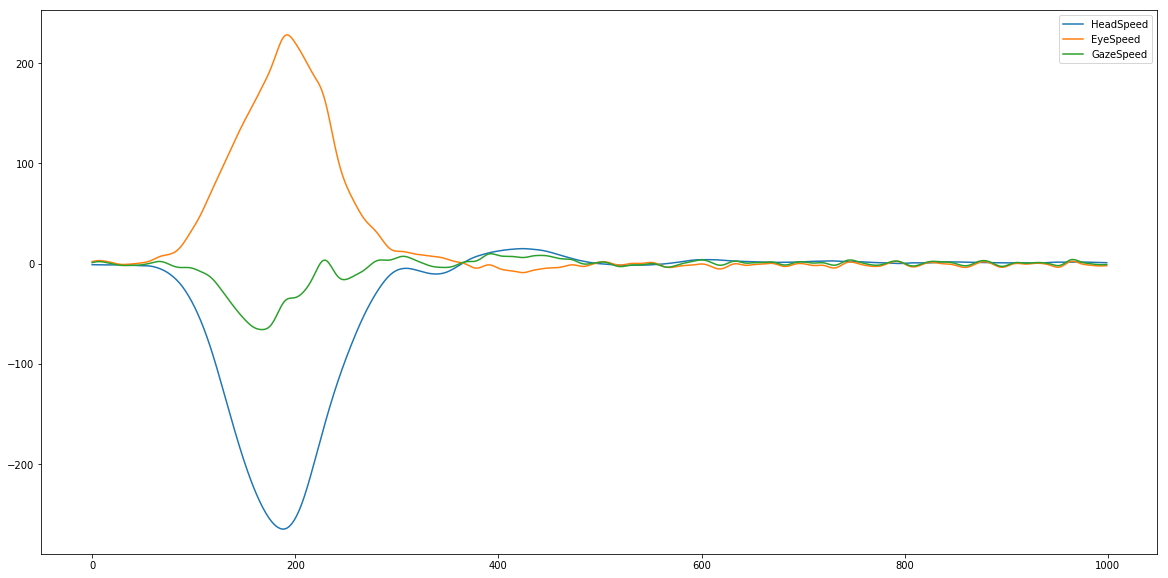

In [18]:
plot_accurate(section,mat_data)